# Imports

In [1]:
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt
import scikitplot             as skplt
import sklearn
import inflection

from sklearn.preprocessing    import MinMaxScaler, StandardScaler
from sklearn                  import model_selection
from sklearn.model_selection  import StratifiedKFold
from sklearn                  import ensemble
from sklearn                  import neighbors
from sklearn                  import linear_model
from sklearn.metrics          import roc_auc_score
from sklearn.ensemble         import RandomForestClassifier
from sklearn.naive_bayes      import GaussianNB
from xgboost                  import XGBClassifier
from lightgbm                 import LGBMClassifier
from catboost                 import CatBoostClassifier
from kds.metrics              import plot_cumulative_gain, plot_lift

from IPython.display          import Image
from IPython.core.display     import HTML

import warnings
warnings.filterwarnings("ignore")

## Helper Functions

### Models Performance

In [2]:
# definition of precision_at_k for the top 20.000 clients as default
def precision_at_k (data, k=2000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate precision based on column named response
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

# definition of recall_at_k for the top 20.000 clients as default
def recall_at_k (data, k=20000):
    
    # reset index
    data = data.reset_index(drop=True)
    
    #create ranking order
    data['ranking'] = data.index + 1
    
    #calculate recall based on the sum of responses
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

##Define models accuracy function
def accuracy (model, x_val, y_val, yhat):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    data['score'] = yhat[:, 1].tolist()
    data = data.sort_values('score', ascending=False)
   
    precision = precision_at_k(data)      
    recall = recall_at_k(data)
    f1_score = round(2*(precision * recall) / (precision + recall), 3)
    roc = roc_auc_score(y_val, yhat[:,1])
    
    return pd.DataFrame({'Model Name': type(model).__name__,
                         'ROC AUC': roc.round(4),
                         'Precision@K Mean': np.mean(precision).round(4),
                         'Recall@K Mean': np.mean(recall).round(4),
                         'F1_Score' : np.mean(f1_score).round(4)}, index=[0])

## Define Cross-Validation
def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    f1_score_list = []
    roc_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision = precision_at_k(data) 
        precision_list.append(precision)
        
        recall = recall_at_k(data)
        recall_list.append(recall)
        
        f1_score = round(2*(precision * recall) / (precision + recall), 3)
        f1_score_list.append(f1_score)
       
        roc = roc_auc_score(y_val_fold, yhat[:, 1])
        roc_list.append(roc)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__,
                         'ROC AUC': roc.round(4),
                         'Precision@K Mean': np.mean(precision).round(4),
                         'Recall@K Mean': np.mean(recall).round(4),
                         'F1_Score' : np.mean(f1_score).round(4)}, index=[0])
    return df

### Graphic

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## Loading Data 

In [4]:
df_raw = pd.read_csv('data/train.csv')

# Data Details

In [5]:
df2 = df_raw.copy()

In [6]:
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Data Dictionary

|The data set that we're using is from Kaggle (https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction).



| Feature                                       |Description   
|:---------------------------|:---------------
| **Id**                         | Unique ID for the customer   | 
| **Gender**                           | Gender of the customer   | 
| **Age**                           | Age of the customer   | 
| **Driving License**                                   | 0, customer does not have DL; 1, customer already has DL  | 
| **Region Code**                               | Unique code for the region of the customer   | 
| **Previously Insured**                     | 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance | 
| **Vehicle Age**                     | Age of the vehicle | 
| **Vehicle Damage**                                  | 1, customer got his/her vehicle damaged in the past; 0, customer didn't get his/her vehicle damaged in the past | 
| **Anual Premium**                             | The amount customer needs to pay as premium in the year | 
| **Policy sales channel**                                    | Anonymized Code for the channel of outreaching to the customer ie  | 
| **Vintage**                | Number of Days, customer has been associated with the company  | 
| **Response**              | 1, customer is interested; 0, customer is not interested. |    

## Rename Columns

In [7]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 
            'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df2.columns = cols_new

## Data Dimensions

In [8]:
print ('Number of Rows: {}'.format( df2.shape[0]))
print ('Number of Columns: {}'.format( df2.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## Data Types

In [9]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## Missing Values

In [10]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## Change Types

In [11]:
# changing data types from float to int64

df2['region_code'] = df2['region_code'].astype('int64')     

df2['policy_sales_channel'] = df2['policy_sales_channel'].astype('int64')    

df2['annual_premium'] = df2['annual_premium'].astype('int64')    


## Descriptive Statistics


In [12]:
# Split numerical and categorical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'])
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64'])

### Numerical Attributes

In [13]:
#Central Tendency - mean, meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat
m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


**Age** of customers ranges from 20 to 85 years old, average being close to 38.

**Driving Licence** ≈ 100% of the clients in analysis retain a one

**Vehicle insurance** ≈ 55% of the clients do not hold one

**Annual Premium** Clients pay ≈ 30.5k on their current health insurance policy

**Response** 12.23% of the clients showed to be interest in purchasing a vehicle insurance.

### Categorical Attributes

In [14]:
# add percentage of most common attribute
cat_attributes_p = cat_attributes.describe().T
cat_attributes_p['freq_p'] = cat_attributes_p['freq'] / cat_attributes_p['count']
cat_attributes_p

,count,unique,top,freq,freq_p
gender,381109,2,Male,206089,0.540761
vehicle_age,381109,3,1-2 Year,200316,0.525613
vehicle_damage,381109,2,Yes,192413,0.504877


**Gender** ≈ 54% of the customers are Male

**Vehicle Age** Customers age vehicle is most commonly between 1 and 2 years old

**Vehicle Damage** ≈ 50% of the customers got his/her vehicle damaged in the past

**TOP 3 Combos Categorical Attributes**

In [15]:
categorical_combo = pd.DataFrame(round(cat_attributes.value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
categorical_combo['count'] = cat_attributes.value_counts().values
display(categorical_combo)

,gender,vehicle_age,vehicle_damage,%,count
0,Male,1-2 Year,Yes,21.0,79533
1,Female,< 1 Year,No,17.0,66047
2,Male,< 1 Year,No,13.0,50543
3,Female,1-2 Year,Yes,13.0,48692
4,Male,1-2 Year,No,11.0,42791
5,Female,1-2 Year,No,8.0,29300
6,Female,< 1 Year,Yes,7.0,25274
7,Male,< 1 Year,Yes,6.0,22922
8,Male,> 2 Years,Yes,3.0,10293
9,Female,> 2 Years,Yes,1.0,5699


**1.** Males with car age between 1-2 years old that got vehicle damaged in the past 

**2.** Female with car newer than 1 year old that never got vehicle damage in the past

**3.** Males with car newer than 1 year old that never got vehicle damage in the past

# Feature Engineering

In [16]:
df3 = df2.copy()

## Features Creation 

In [17]:
# vehicle age
df3['vehicle_age']= df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2year' if x== '1-2 Year' else 'between_1_2_year')
# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

## Mind Map

# Exploratory Data Analysis (EDA)

In [18]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

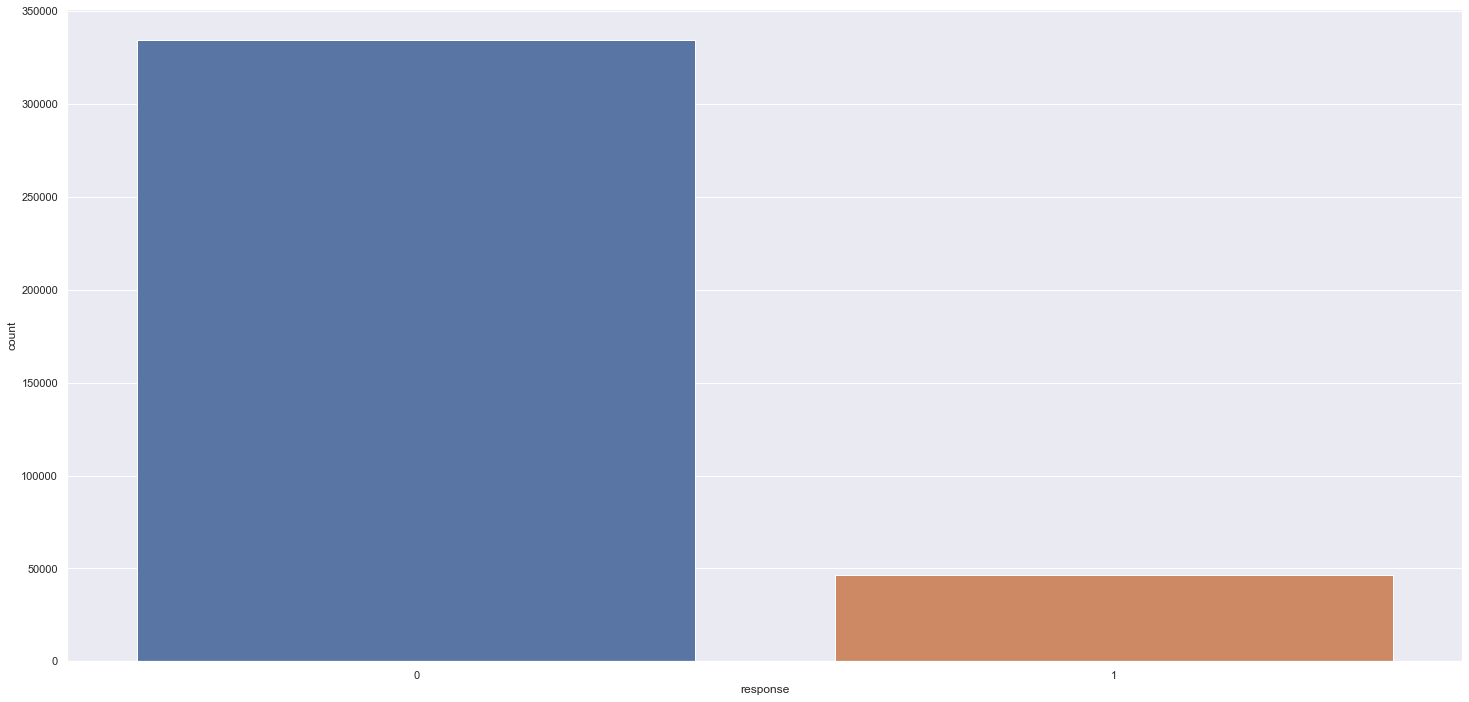

In [19]:
sns.countplot(x = 'response', data=df4);

### Numerical Variables

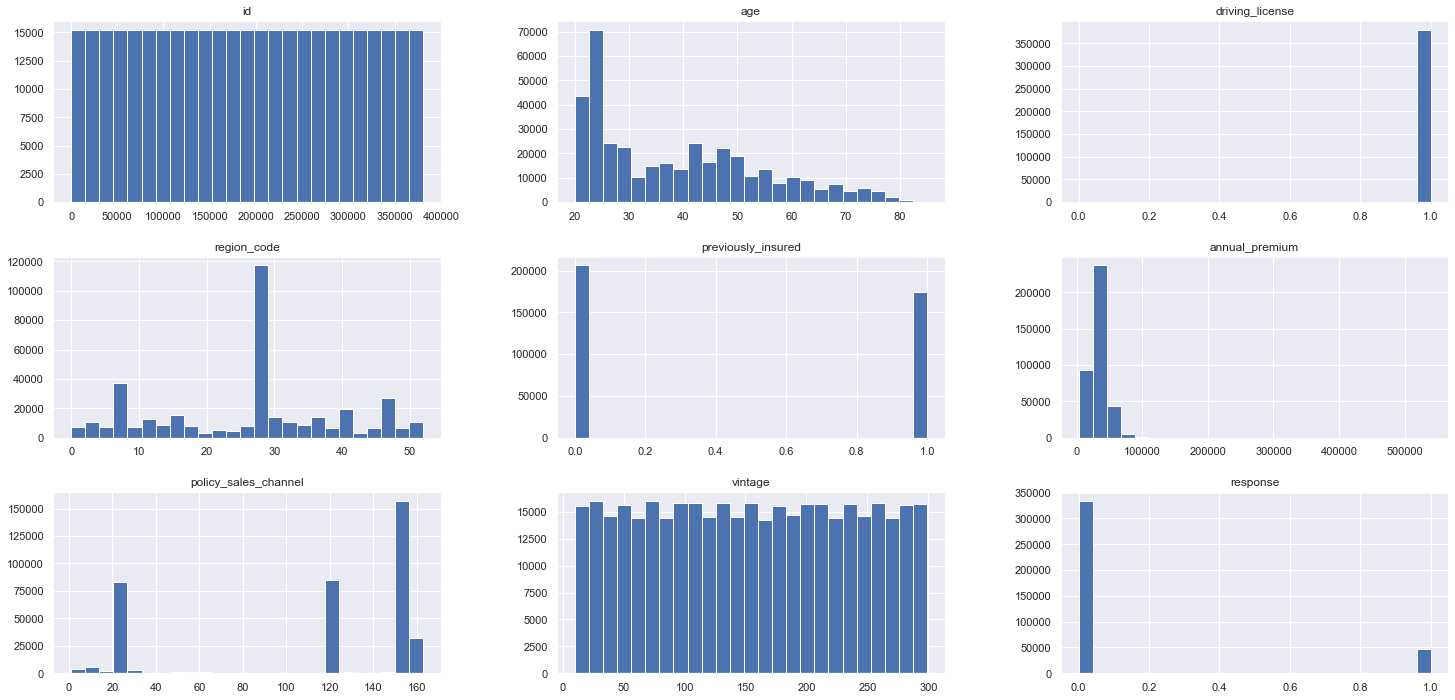

In [20]:
num_attributes.hist(bins=25);

#### Age

**Findings** The average age of interested clients is higher than non-interested clients. Both plots disclose well how younger clients are not as interested as older clients.

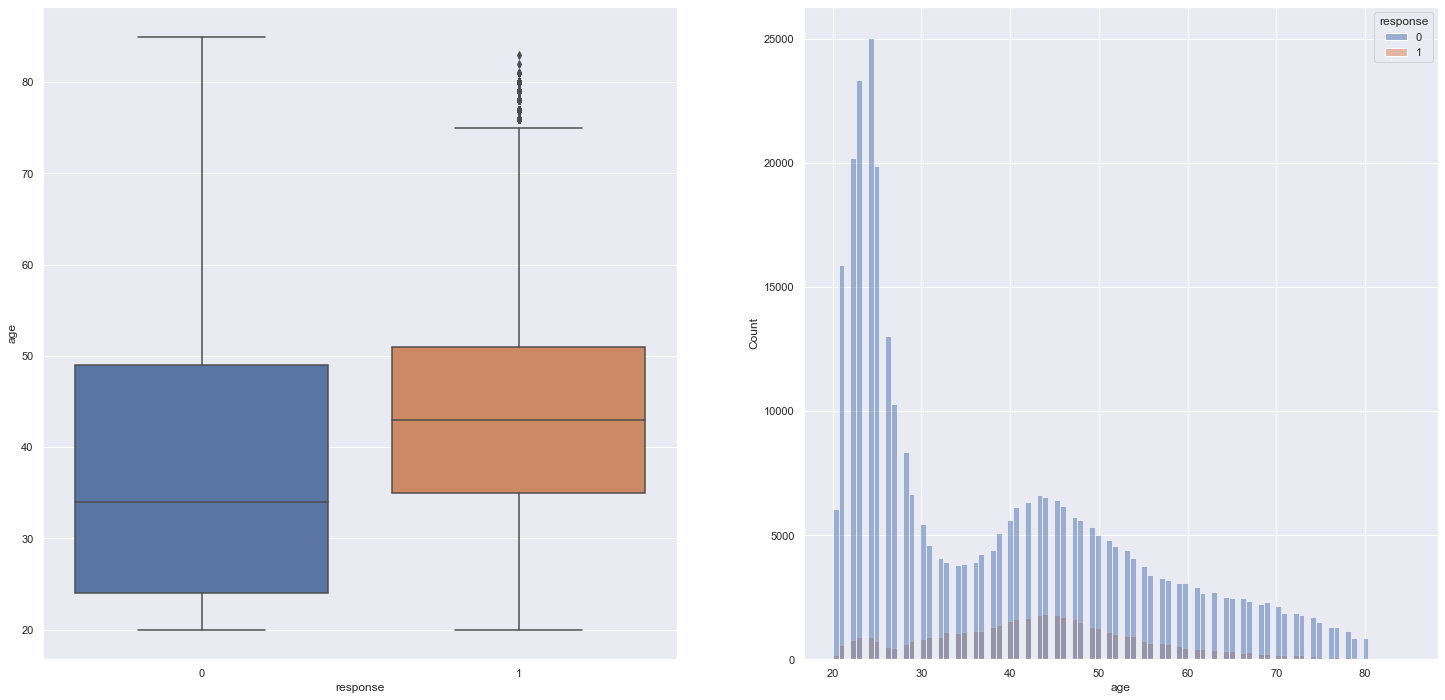

In [21]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='age', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='age', hue='response');

#### Driving Licence
**Findings** Only clients holding a driving license are part of the dataset. 12% are potential vehicle insurance customers

In [22]:
aux2 = pd.DataFrame(round(df4[['driving_license', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux2['count'] = (aux2['%'] * df4.shape[0]).astype(int)
aux2

,driving_license,response,%,count
0,1,0,88.0,33537592
1,1,1,12.0,4573308
2,0,0,0.0,0
3,0,1,0.0,0


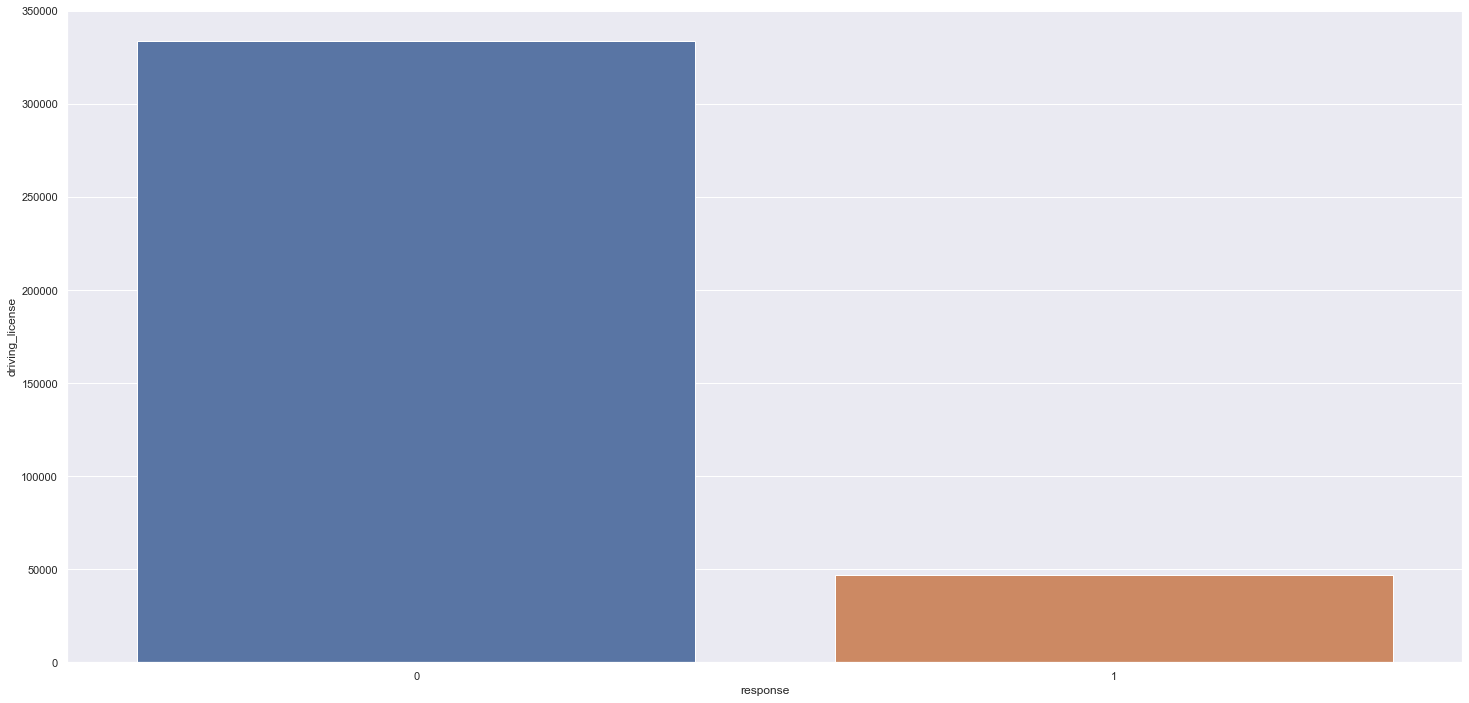

In [23]:
aux2 = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux2 );

#### Region Code

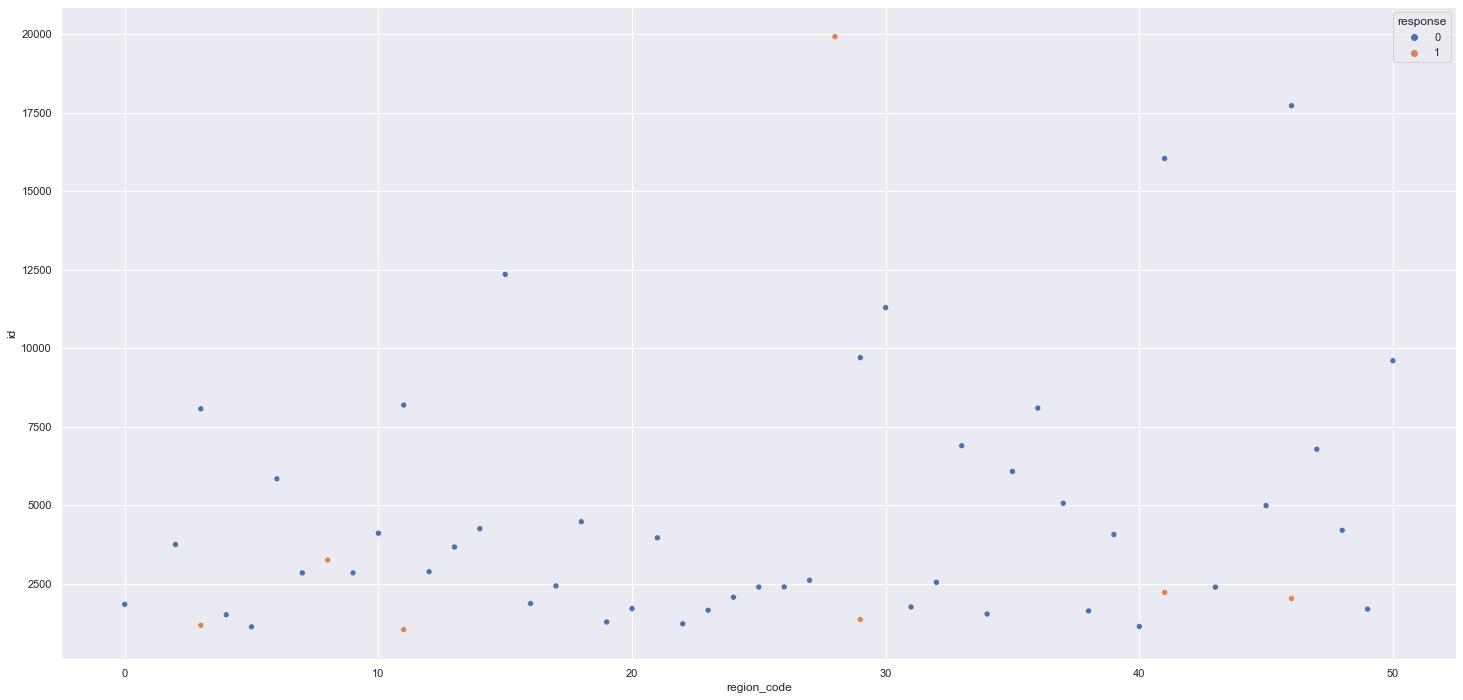

In [24]:
aux3 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
aux3 = aux3[(aux3['id'] > 1000) & (aux3['id'] < 20000)]
sns.scatterplot( x='region_code', y='id', hue='response', data=aux3 );

#### Previously Insured
**Findings** All potential vehicle insurance customers have never held an insurance. 46% of our clients already have vehicle insurance and are not interested.

In [25]:
aux4 = pd.DataFrame(round(df4[['previously_insured', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux4['count'] = (aux4['%'] * df4.shape[0]).astype(int)
aux4

,previously_insured,response,%,count
0,1,0,46.0,17531014
1,0,0,42.0,16006578
2,0,1,12.0,4573308
3,1,1,0.0,0


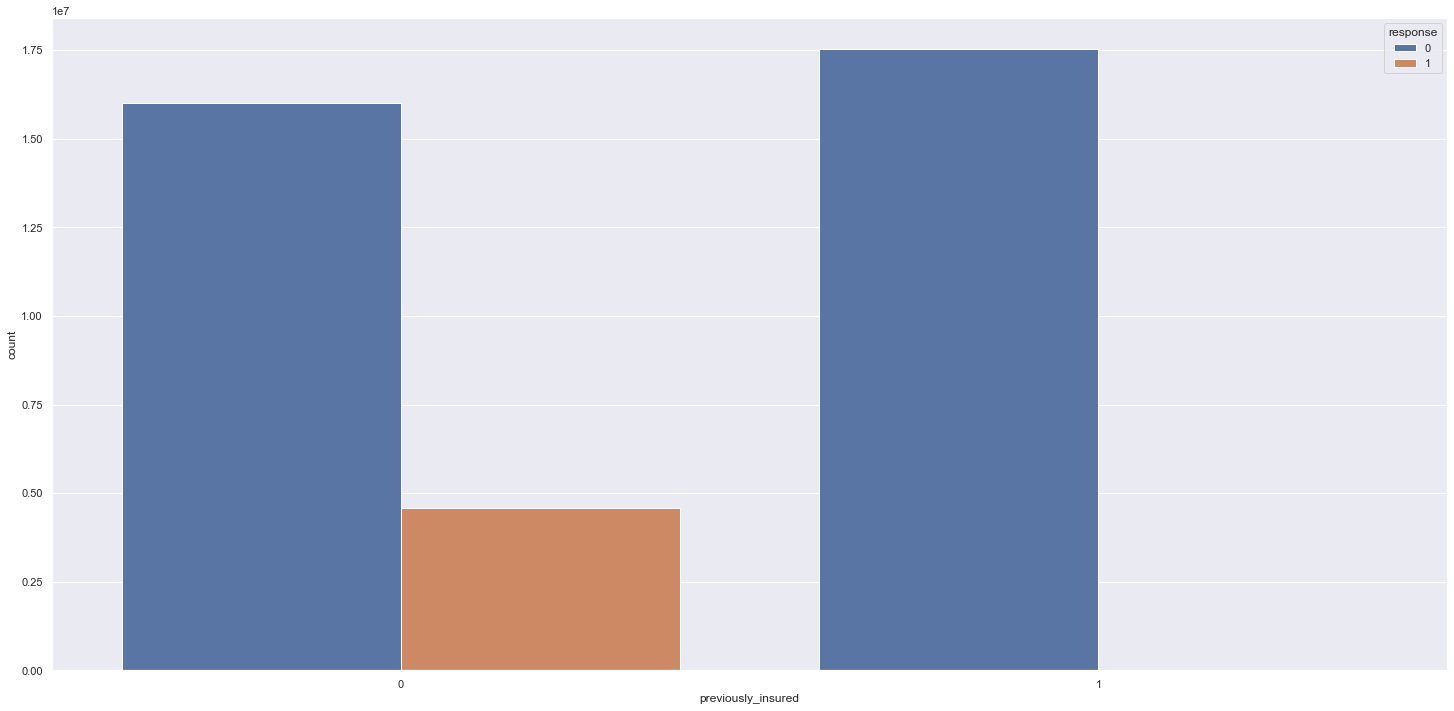

In [26]:
sns.barplot(data=aux4, x='previously_insured', y='count', hue='response');

#### Annual Premium
**Findings** Annual premiums for both interested and non-interested clients are very similar.

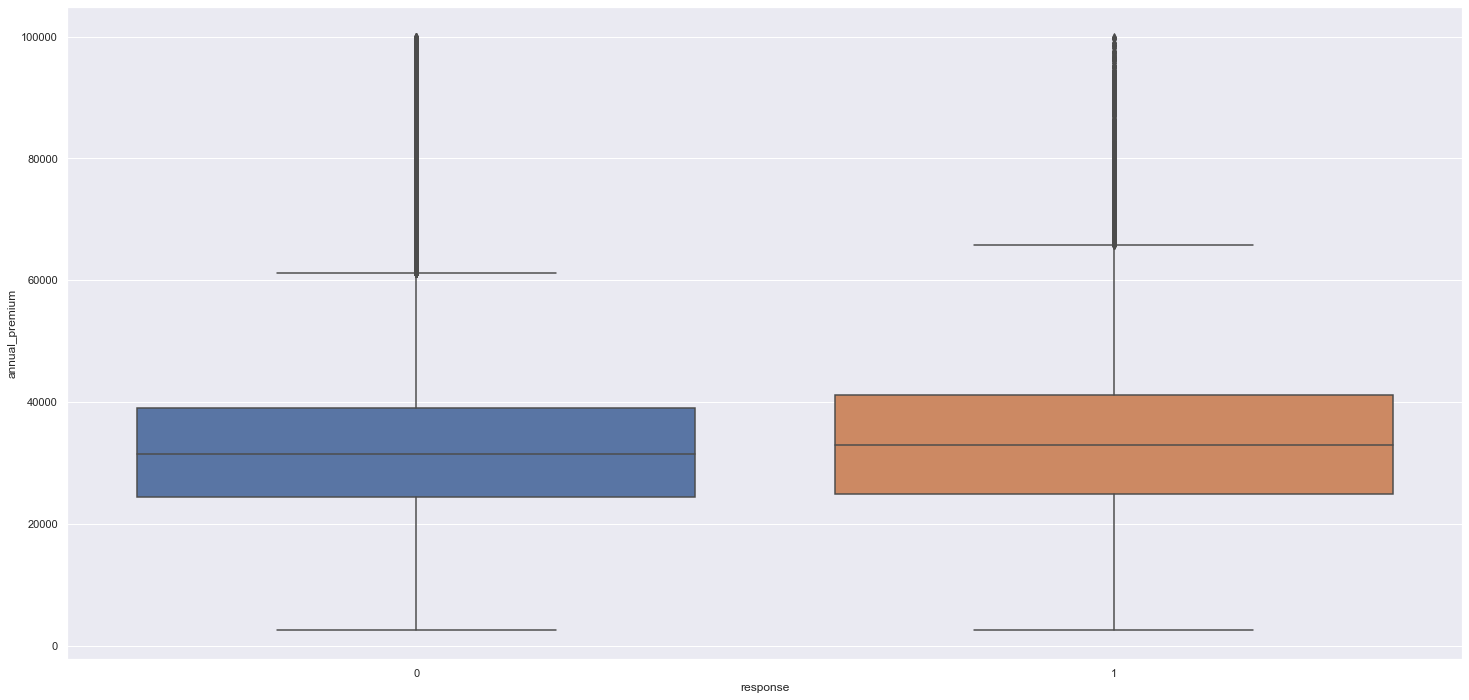

In [27]:
aux5 = df4[(df4['annual_premium'] <100000)]
sns.boxplot( x='response', y='annual_premium', data=aux5 );

#### Policy Sales Channel
**Findings**

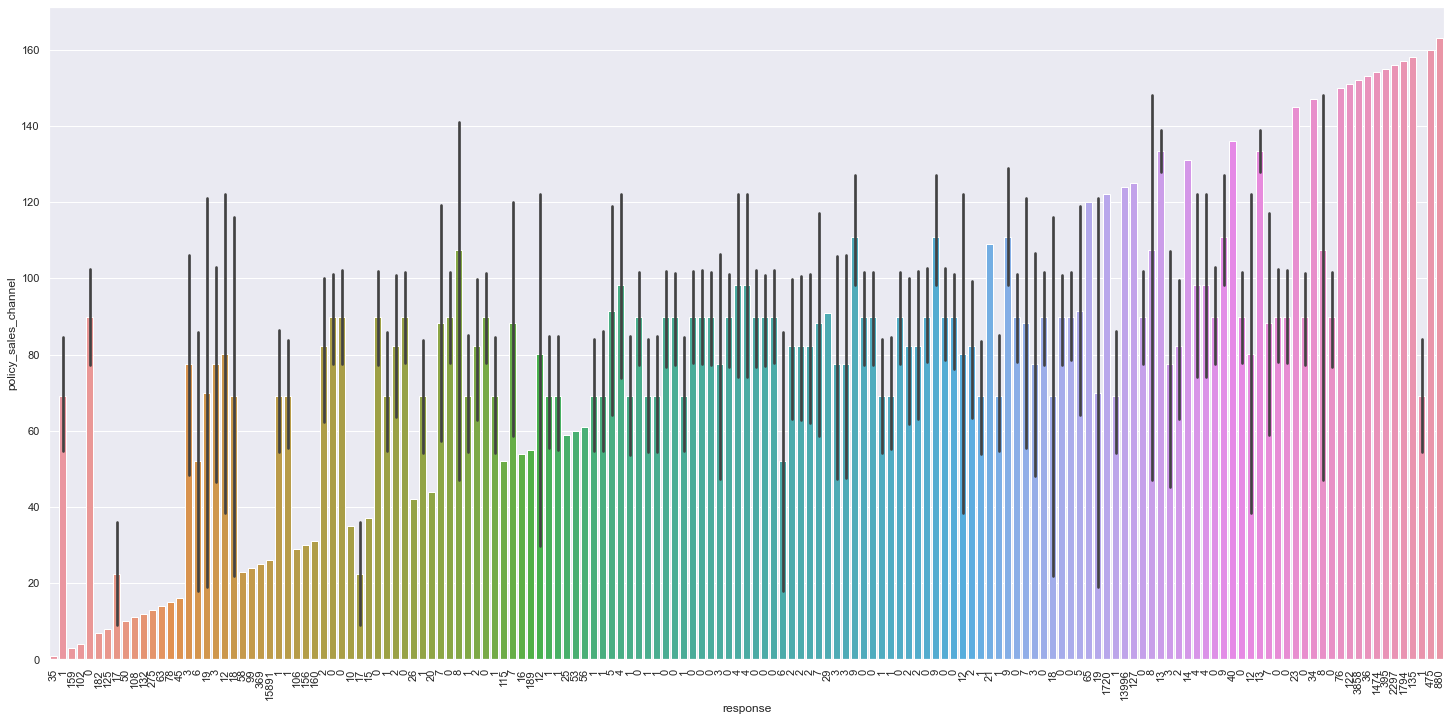

In [28]:
aux6 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.xticks(rotation=90)
ax6 = sns.barplot( x='response', y='policy_sales_channel', data=aux6, order = aux6['response']);

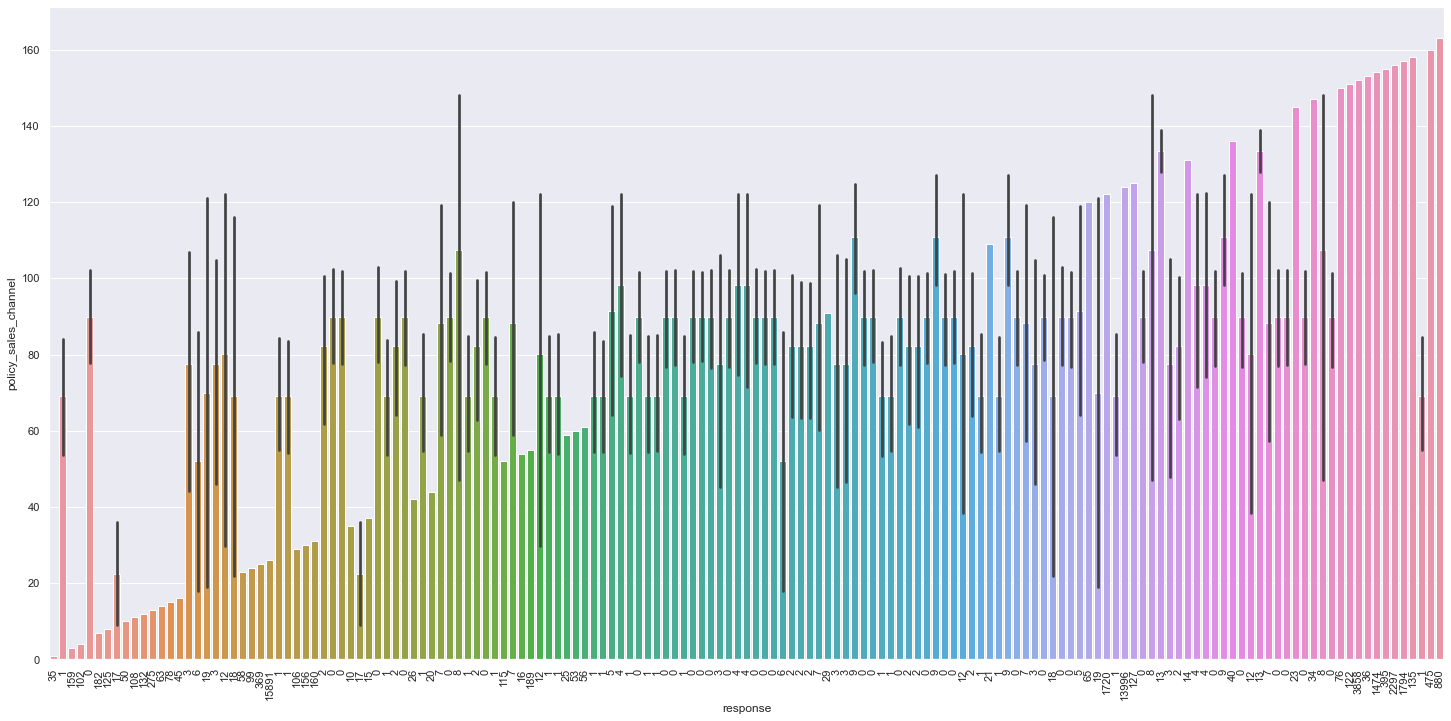

In [29]:
aux6 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()

plt.xticks(rotation=90)
ax6 = sns.barplot( x='response', y='policy_sales_channel', data=aux6, order = aux6['response']);

#### Vintage
**Findings**

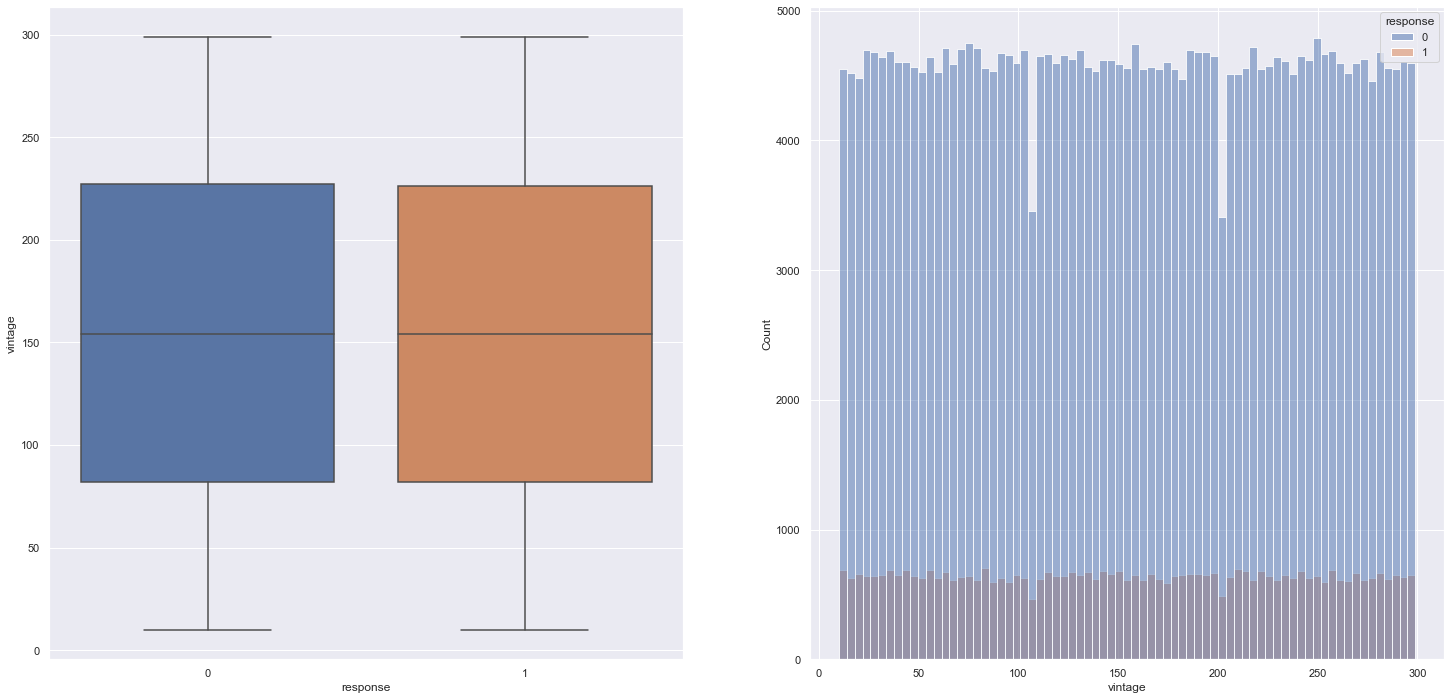

In [30]:
plt.subplot(1, 2, 1)
sns.boxplot( x='response', y='vintage', data=df4 )

plt.subplot(1, 2, 2)
sns.histplot(df4, x='vintage', hue='response');

### Categorical Variables

#### Gender

In [31]:
aux7 = pd.DataFrame(round(df4[['gender', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux7['count'] = (aux7['%'] * df4.shape[0]).astype(int)
aux7

,gender,response,%,count
0,Male,0,47.0,17912123
1,Female,0,41.0,15625469
2,Male,1,7.0,2667763
3,Female,1,5.0,1905545


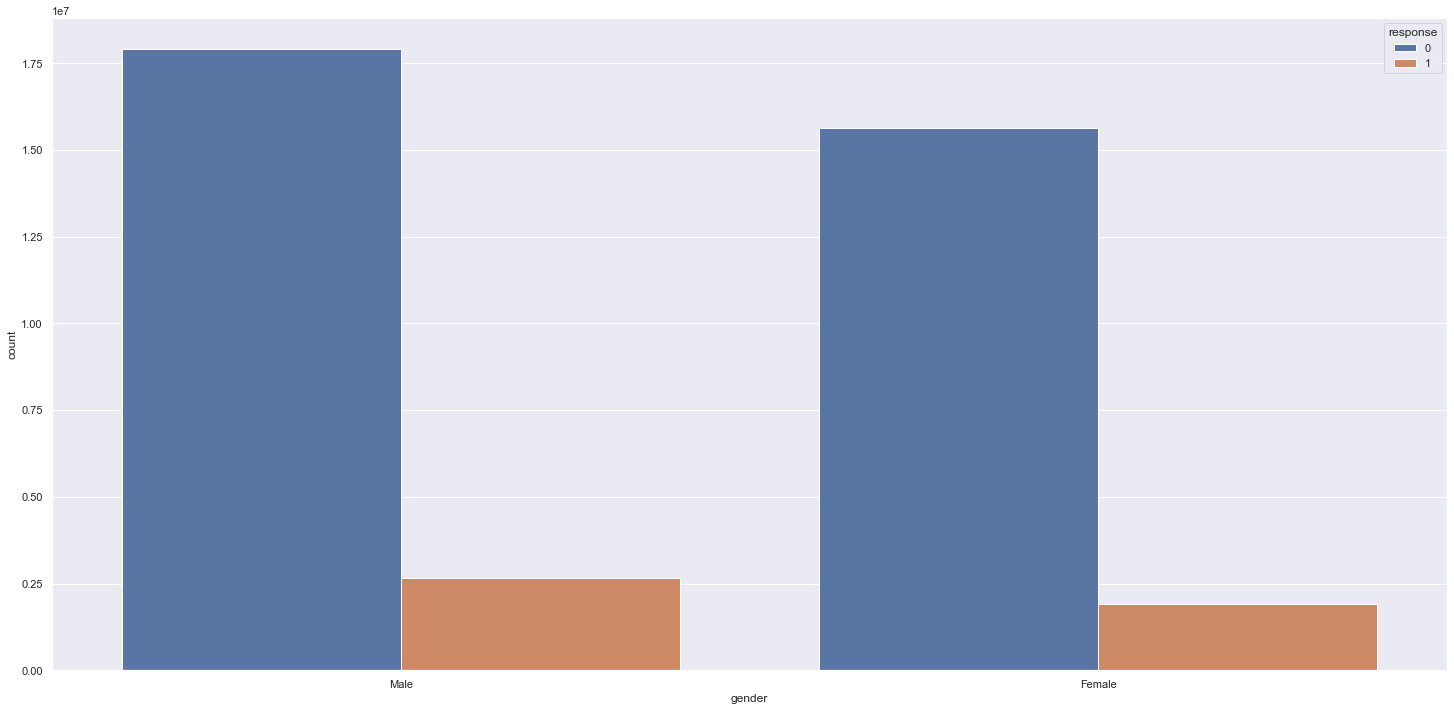

In [32]:
sns.barplot(data=aux7, x='gender', y='count', hue='response');

#### Vehicle Age

In [33]:
aux8 = pd.DataFrame(round(df4[['vehicle_age', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux8['count'] = (aux8['%'] * df4.shape[0]).astype(int)
aux8

,vehicle_age,response,%,count
0,between_1_2year,0,43.0,16387687
1,between_1_2_year,0,41.0,15625469
2,between_1_2year,1,9.0,3429981
3,over_2_years,0,3.0,1143327
4,between_1_2_year,1,2.0,762218
5,over_2_years,1,1.0,381109


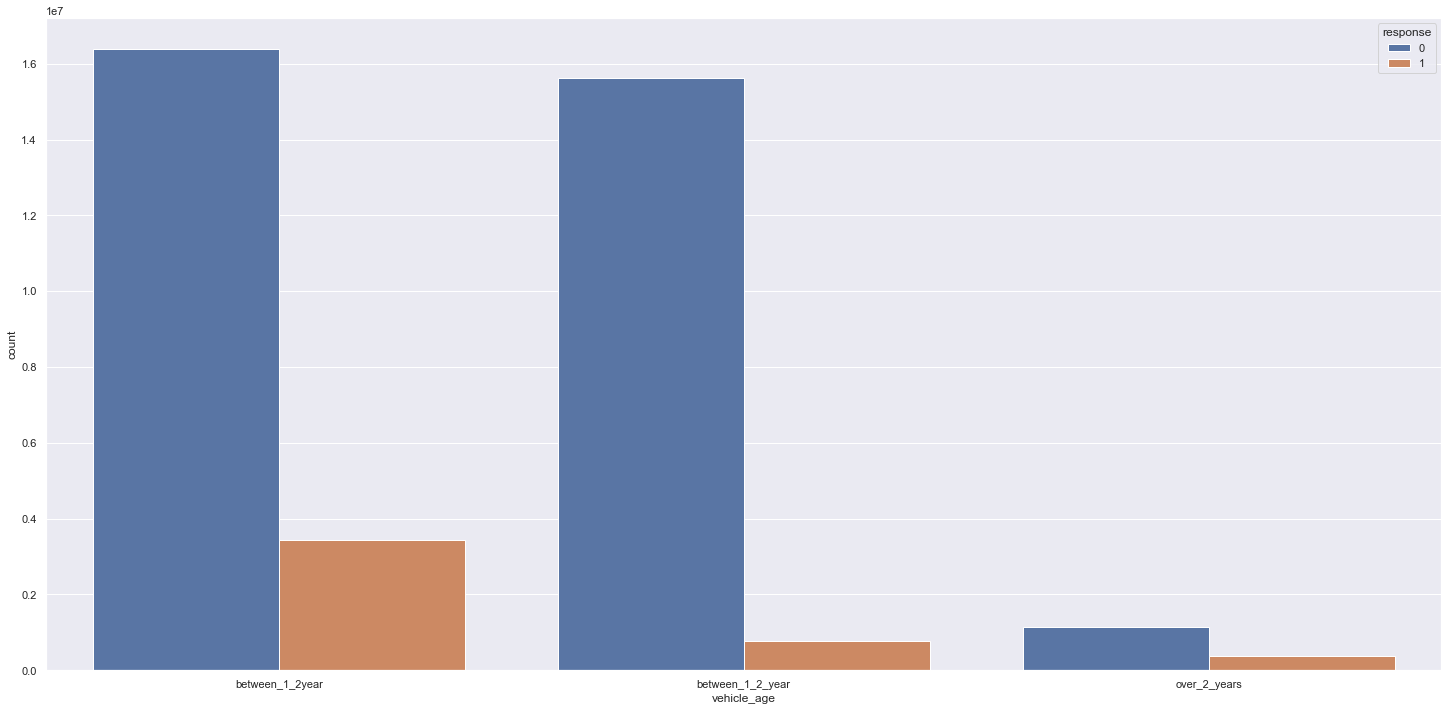

In [34]:
sns.barplot(data=aux8, x='vehicle_age', y='count', hue='response');

#### Vehicle Damage

In [35]:
aux9 = pd.DataFrame(round(df4[['vehicle_damage', 'response']].value_counts(normalize=True) * 100)).reset_index().rename(columns={0: '%'})
aux9['count'] = (aux9['%'] * df4.shape[0]).astype(int)
aux9

,vehicle_damage,response,%,count
0,0,0,49.0,18674341
1,1,0,38.0,14482142
2,1,1,12.0,4573308
3,0,1,0.0,0


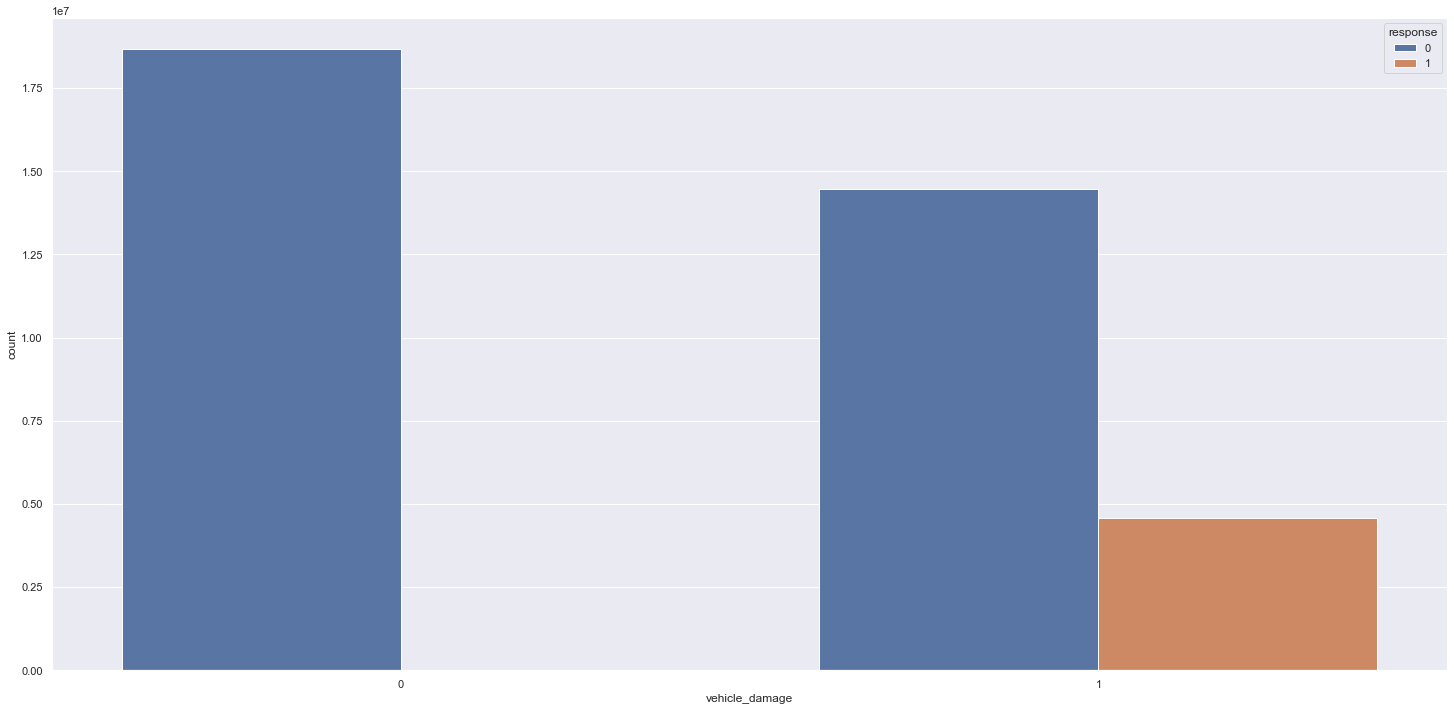

In [36]:
sns.barplot(data=aux9, x='vehicle_damage', y='count', hue='response');

## Bivariate Analysis

## Multivariate Analysis

### Numerical Attributed
**Finding** Having the target variable in scope, the stronger correlations with feature 'Previously Insured' (-0.34), 'Policy Sales Channel' (-0.14) and 'Age' (0.11). Outside the target variable scope, between Age and Policy Sales Chanel there is strong negative correlation of -0.58), 'Previously Insured' and 'Age' of -0.25 and last between 'Previously Insured' and 'Policy Sales Channel' 0.22. 

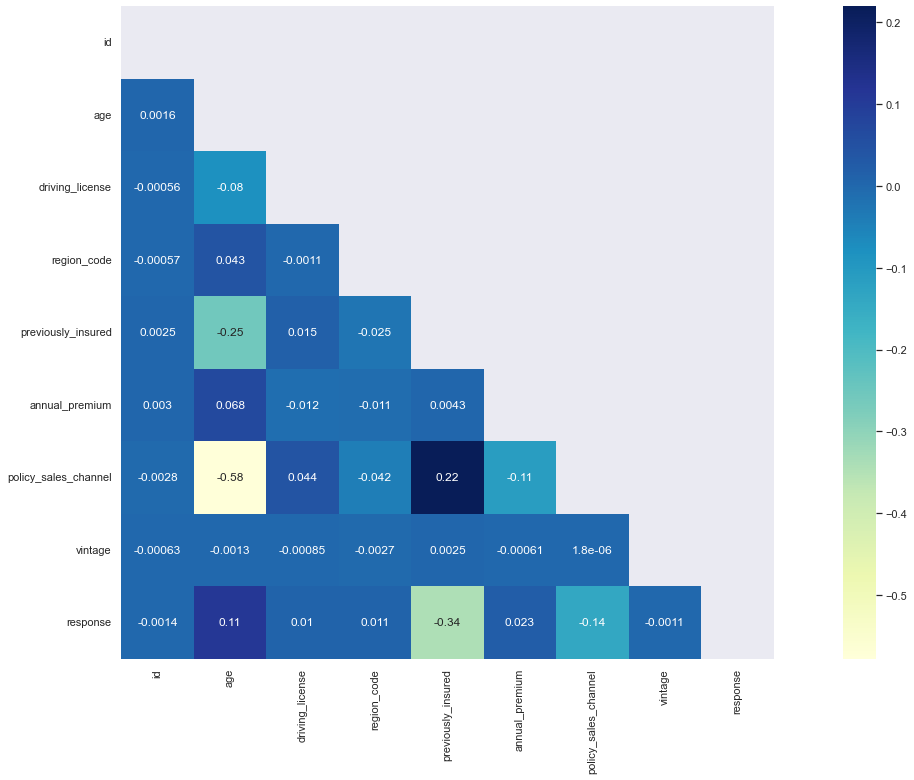

In [37]:
corr_matrix= num_attributes.corr()
# Half matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask = mask, annot = True, square = True, cmap='YlGnBu');

# Data Preparation

In [38]:
df5 = df4.copy()

## Standardization of DataSets 

In [39]:
df5['annual_premium'] = StandardScaler().fit_transform( df5[['annual_premium']].values)

## Rescaling

In [40]:
mms = MinMaxScaler()

#age
df5['age'] = mms.fit_transform( df5[['age']].values)

#vintage
df5['vintage'] = mms.fit_transform( df5[['vintage']].values)

## Transformation

### Encoding

In [41]:
#gender - target encoder
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding - as there are plenty of categories (as seen in EDA) it is better not to use one hot encoding and to use 
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

#vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#policy_sales_channel - Frequency encode
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len( df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# Feature Selection

In [42]:
df6 = df5.copy()

## Split dataframe into training and test

In [43]:
X = df6.drop('response', axis=1)
y = df6['response'].copy()

x_train, x_val, y_train, y_val = model_selection.train_test_split(X, y, test_size = 0.2)

df6 = pd.concat ( [x_train, y_train], axis = 1)

## Feature Importance

In [44]:
forest = ensemble.ExtraTreesClassifier( n_estimators = 250, random_state = 42, n_jobs = -1)

x_train_n = df6.drop(['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature Rankings
                        feature  importance
0                       vintage    0.272992
0                annual_premium    0.245147
0                           age    0.163518
0                   region_code    0.106784
0                vehicle_damage    0.073442
0          policy_sales_channel    0.061629
0            previously_insured    0.050056
0  vehicle_age_between_1_2_year    0.012089
0   vehicle_age_between_1_2year    0.006013
0                        gender    0.005289
0      vehicle_age_over_2_years    0.002570
0               driving_license    0.000470


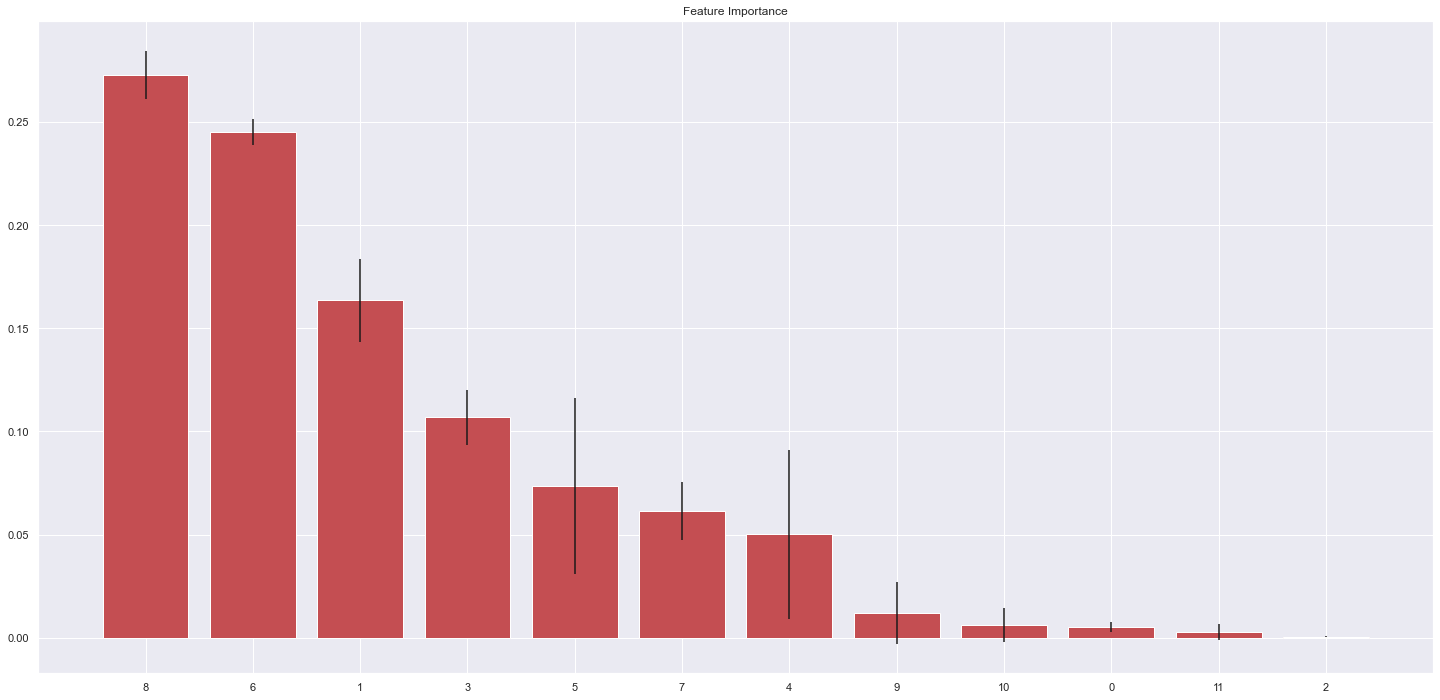

In [45]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
#print the feature ranking
print( "Feature Rankings")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance':j}, index=[0])
    df = pd.concat ([df, aux], axis = 0)
    
print( df.sort_values( 'importance', ascending=False))

# PLt the impurity-based feature importance of the features
plt.figure()
plt.title('Feature Importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# Machine Learning Modelling

In [46]:
#I will use as well 'driving_license' as it seemes an importante feature in EDA
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel', 'driving_license']

cols_not_selected = ['previously_insured', 'vehicle_age_between_1_2_year', 'vehicle_age_between_1_2year', 'gender', 'vehicle_age_over_2_years']

#create df to be used for business understading
x_validation = x_val.drop(cols_not_selected, axis=1)

#create dfs for modeling
x_train = df6[cols_selected]
x_val = x_val[cols_selected]

## Logistic Regression

### Model Building

In [47]:
#define model
lr = linear_model.LogisticRegression (random_state = 42)

#train model
lr.fit( x_train, y_train)

#model prediction
yhat_lr = lr.predict_proba( x_val)

### Model Single Performance

In [48]:
accuracy_lr = accuracy(lr, x_val, y_val, yhat_lr)
accuracy_lr

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LogisticRegression,0.8065,0.2864,0.593,0.386


### Cross Validation Performance

In [49]:
accuracy_cv_lr = cross_validation(lr, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_lr

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LogisticRegression,0.8044,0.2909,0.7193,0.414


### Performance Plotted

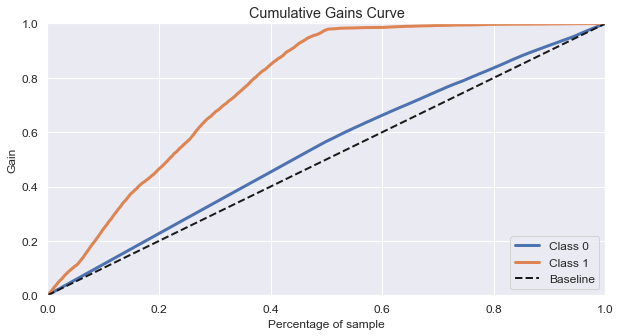

In [50]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, figsize = (10, 5));

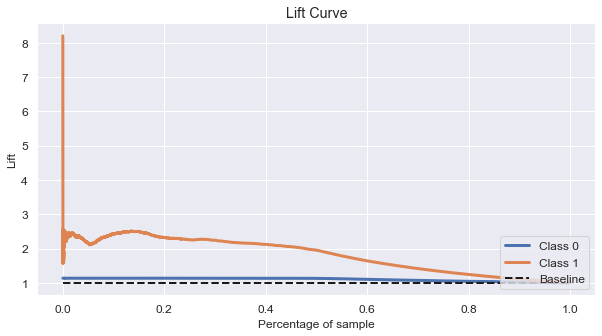

In [51]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr, figsize = (10, 5) );

## Naive Bayes

### Model Building

In [52]:
#define model
naive = GaussianNB()

#train model
naive.fit( x_train, y_train)

#model prediction
yhat_naive = naive.predict_proba( x_val)

### Model Single Performance

In [53]:
accuracy_naive = accuracy(naive, x_val, y_val, yhat_naive)
accuracy_naive

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,GaussianNB,0.8165,0.2984,0.6197,0.403


### Cross Validation Performance

In [54]:
accuracy_cv_naive = cross_validation(naive, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_naive

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,GaussianNB,0.8136,0.2874,0.7521,0.416


### Performance Plotted

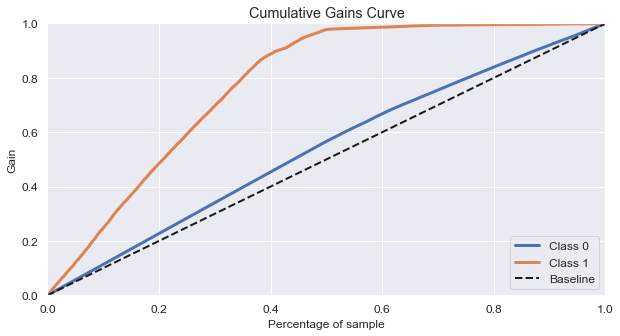

In [55]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_naive, figsize = (10, 5));

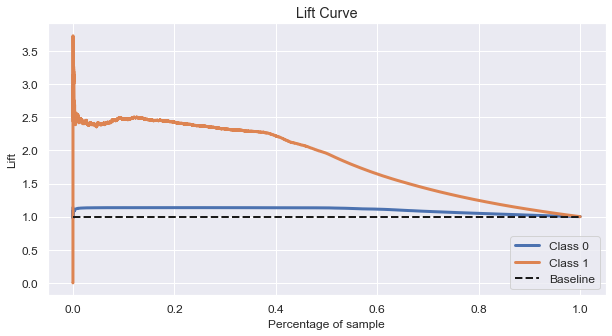

In [56]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_naive, figsize = (10, 5) );

## Extra Trees

### Model Building

In [57]:
#define model
et = ensemble.ExtraTreesClassifier (random_state = 42, n_jobs=-1)

#train model
et.fit( x_train, y_train)

#model prediction
yhat_et = et.predict_proba( x_val)

### Model Single Performance

In [58]:
accuracy_et = accuracy(et, x_val, y_val, yhat_et)
accuracy_et

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,ExtraTreesClassifier,0.8093,0.3163,0.6262,0.42


### Cross Validation Performance

In [59]:
accuracy_cv_et = cross_validation(et, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_et

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,ExtraTreesClassifier,0.8075,0.3263,0.7382,0.453


### Performance Plotted

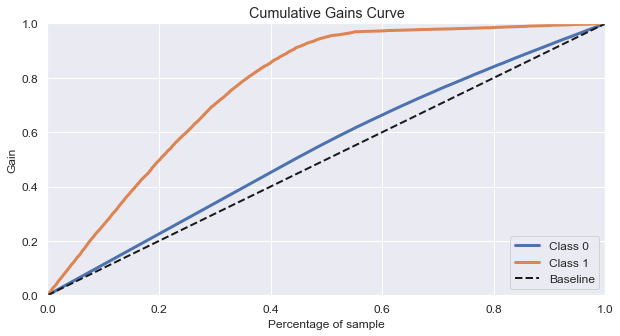

In [60]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, figsize = (10, 5));

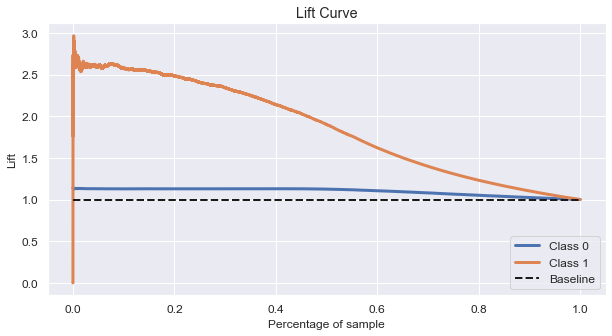

In [61]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_et, figsize = (10, 5) );

## Random Forest Regressor

### Model Building

In [62]:
#define model
rf=RandomForestClassifier(n_estimators=100, min_samples_leaf=25)

#train model
rf.fit( x_train, y_train)

#model prediction
yhat_rf = rf.predict_proba( x_val)

### Model Single Performance

In [63]:
accuracy_rf = accuracy(rf, x_val, y_val, yhat_rf)
accuracy_rf

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,RandomForestClassifier,0.8446,0.3978,0.6939,0.506


### Cross Validation Performance

In [64]:
accuracy_cv_rf = cross_validation(rf, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_rf

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,RandomForestClassifier,0.8419,0.3928,0.8055,0.528


### Performance Plotted

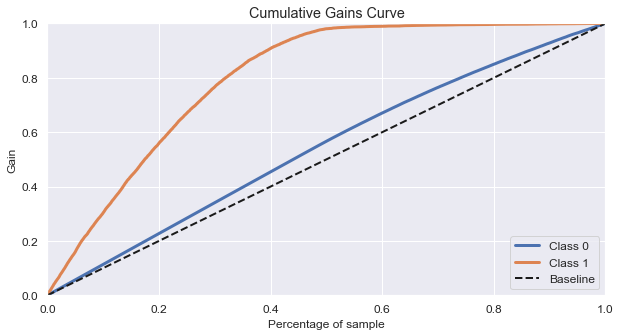

In [65]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, figsize = (10, 5));

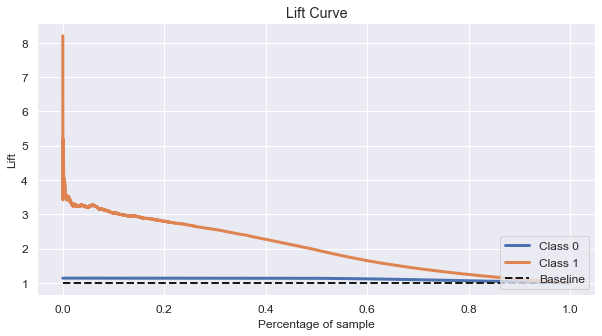

In [66]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf, figsize = (10, 5) );

## KNN Classifier

### Model Building

In [67]:
#define model
knn = neighbors.KNeighborsClassifier (n_neighbors = 8)

#train model
knn.fit( x_train, y_train)

#model prediction
yhat_knn = knn.predict_proba( x_val)

### Model Single Performance

In [68]:
accuracy_knn = accuracy(knn, x_val, y_val, yhat_knn)
accuracy_knn

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,KNeighborsClassifier,0.7816,0.3318,0.6164,0.431


### Cross Validation Performance

In [69]:
accuracy_cv_knn = cross_validation(knn, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_knn

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,KNeighborsClassifier,0.7772,0.3373,0.7161,0.459


### Performance Plotted

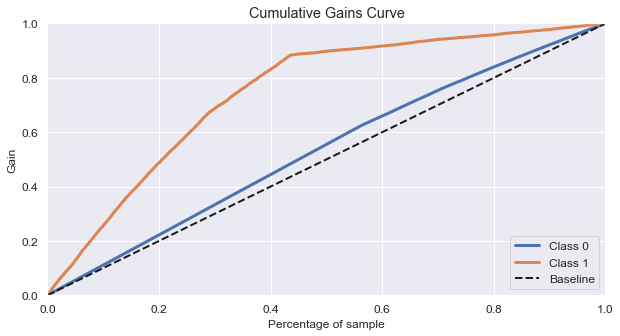

In [70]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, figsize = (10, 5));

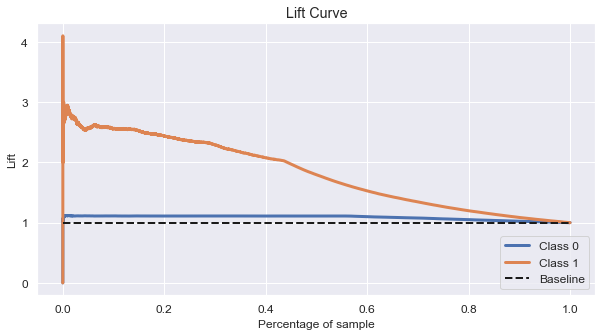

In [71]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn, figsize = (10, 5) );

### Cross Validation

## XGBoost Classifier

### Model Building

In [72]:
#define model
xgboost = XGBClassifier(objective='binary:logistic',
                        eval_metric='error',
                        n_estimators = 100,
                        random_state = 22)

#train model
xgboost.fit( x_train, y_train)

#model prediction
yhat_xgboost = xgboost.predict_proba( x_val)

### Model Single Performance

In [73]:
accuracy_xgboost = accuracy(xgboost, x_val, y_val, yhat_xgboost)
accuracy_xgboost

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,XGBClassifier,0.8456,0.4068,0.6978,0.514


### Cross Validation Performance

In [74]:
accuracy_cv_xgboost = cross_validation(xgboost, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_xgboost

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,XGBClassifier,0.8417,0.3878,0.8063,0.524


### Performance Plotted

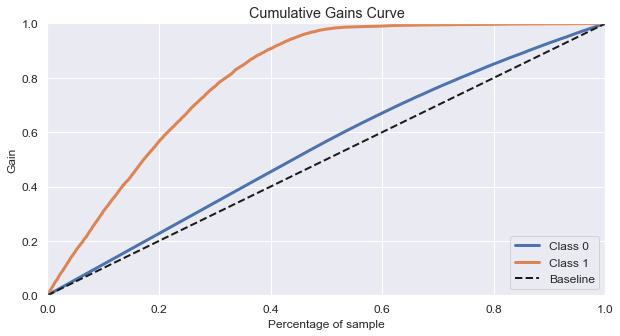

In [75]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgboost, figsize = (10, 5));

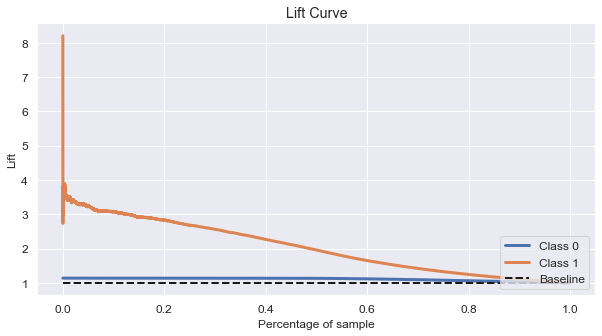

In [76]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_xgboost, figsize = (10, 5) );

## LightGBM Classifier

### Model Building

In [77]:
#define model
lgbm = LGBMClassifier(random_state = 22)

#train model
lgbm.fit( x_train, y_train)

#model prediction
yhat_lgbm = lgbm.predict_proba( x_val)

### Model Single Performance

In [78]:
accuracy_lgbm = accuracy(lgbm, x_val, y_val, yhat_lgbm)
accuracy_lgbm

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8468,0.4063,0.6991,0.514


### Cross Validation Performance

In [79]:
accuracy_cv_lgbm = cross_validation(lgbm, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_lgbm

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8441,0.3948,0.8107,0.531


### Performance Plotted

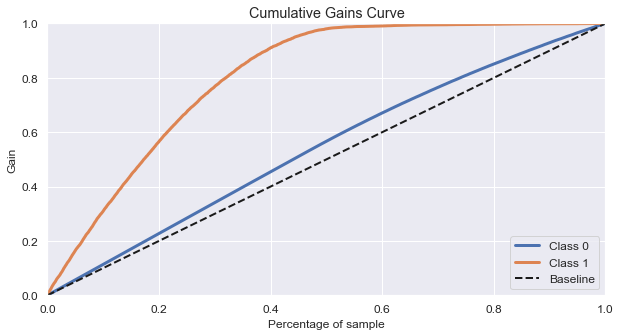

In [80]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm, figsize = (10, 5));

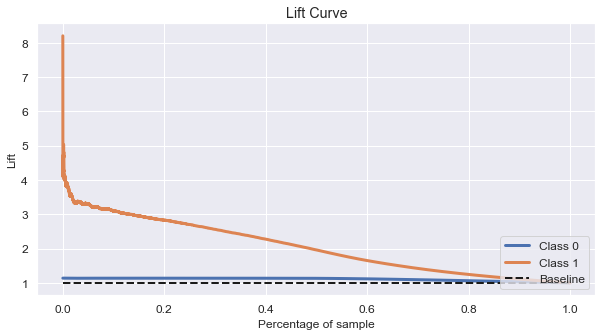

In [81]:
# Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm, figsize = (10, 5) );

## CatBoost Classifier

### Model Building

In [82]:
#define model
catboost = CatBoostClassifier(verbose = False, random_state = 22)

#train model
catboost.fit( x_train, y_train)

#model prediction
yhat_catboost = catboost.predict_proba( x_val)

### Model Single Performance

In [83]:
accuracy_catboost = accuracy(catboost, x_val, y_val, yhat_catboost)
accuracy_catboost

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8461,0.3993,0.7016,0.509


### Cross Validation Performance

In [84]:
accuracy_cv_catboost = cross_validation(catboost, x_train, y_train, 5, df6, Verbose = True)
accuracy_cv_catboost

Fold Number 1/5
Fold Number 2/5
Fold Number 3/5
Fold Number 4/5
Fold Number 5/5


,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8428,0.3908,0.8055,0.526


### Performance Plotted

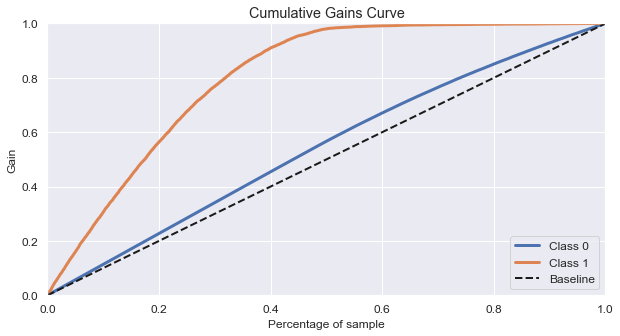

In [85]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_catboost, figsize = (10, 5));

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

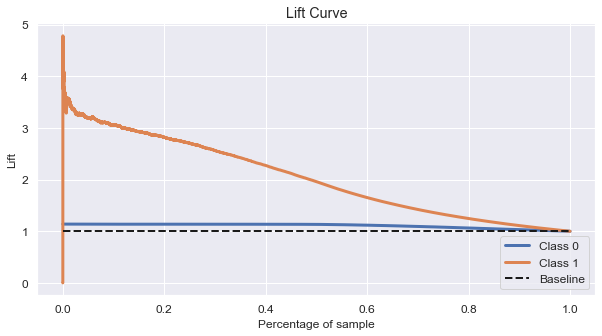

In [86]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_catboost, figsize=(10, 5));

## Comparing Models Preformance

### Single Performance

In [87]:
models_results = pd.concat([accuracy_lr, accuracy_naive, accuracy_et, accuracy_rf, accuracy_knn, accuracy_xgboost, accuracy_lgbm, accuracy_catboost])
models_results.sort_values('Recall@K Mean', ascending = False)

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8461,0.3993,0.7016,0.509
0,LGBMClassifier,0.8468,0.4063,0.6991,0.514
0,XGBClassifier,0.8456,0.4068,0.6978,0.514
0,RandomForestClassifier,0.8446,0.3978,0.6939,0.506
0,ExtraTreesClassifier,0.8093,0.3163,0.6262,0.420
0,GaussianNB,0.8165,0.2984,0.6197,0.403
0,KNeighborsClassifier,0.7816,0.3318,0.6164,0.431
0,LogisticRegression,0.8065,0.2864,0.5930,0.386


### Cross Validation Performance

In [88]:
models_results_cv = pd.concat([accuracy_cv_lr, accuracy_cv_naive, accuracy_cv_et, accuracy_cv_rf, accuracy_cv_knn, accuracy_cv_xgboost, accuracy_cv_lgbm, accuracy_cv_catboost])
models_results_cv.sort_values('Recall@K Mean', ascending = False)

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,LGBMClassifier,0.8441,0.3948,0.8107,0.531
0,XGBClassifier,0.8417,0.3878,0.8063,0.524
0,RandomForestClassifier,0.8419,0.3928,0.8055,0.528
0,CatBoostClassifier,0.8428,0.3908,0.8055,0.526
0,GaussianNB,0.8136,0.2874,0.7521,0.416
0,ExtraTreesClassifier,0.8075,0.3263,0.7382,0.453
0,LogisticRegression,0.8044,0.2909,0.7193,0.414
0,KNeighborsClassifier,0.7772,0.3373,0.7161,0.459


# Hyperparameter Fine Tuning

## Random Search

In [89]:
import random

param = {'depth' : [1, 2, 5, 10, 16],
         'iterations': [50, 100],
         'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
         'l2_leaf_reg' : [1, 2, 5, 10, 100],
         'border_count' : [5, 25, 50, 100, 200],
         'random_state' : [22]
        }

MAX_EVAL = 10

In [90]:
final_result = pd.DataFrame({'ROC AUC': [], 'Precision@K Mean': [], 'Recall@K Mean': [], 'F1_Score': [] })

for i in range ( MAX_EVAL ):
    
    ## choose randomly values for parameters
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( 'Step ' +str(i +1) + '/' + str(MAX_EVAL))
    print( hp )
    # model
    model_catboost = CatBoostClassifier(depth=hp['depth'],
                          iterations = hp['iterations'],
                          learning_rate=hp['learning_rate'],
                          l2_leaf_reg=hp['l2_leaf_reg'],
                          border_count =hp['border_count'],
                          random_state=hp['random_state'])


    # performance
    model_catboost_result = cross_validation(model_catboost, x_train, y_train, 5, df6, Verbose = False)
    final_result = pd.concat([final_result, model_catboost_result])
    
final_result.sort_values('Recall@K Mean', ascending = False)

Step 1/10
{'depth': 10, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 100, 'border_count': 5, 'random_state': 22}
0:	learn: 0.5804428	total: 44.7ms	remaining: 2.19s
1:	learn: 0.5155385	total: 102ms	remaining: 2.44s
2:	learn: 0.4595599	total: 139ms	remaining: 2.18s
3:	learn: 0.4194958	total: 185ms	remaining: 2.12s
4:	learn: 0.3926197	total: 244ms	remaining: 2.19s
5:	learn: 0.3675928	total: 286ms	remaining: 2.1s
6:	learn: 0.3489179	total: 318ms	remaining: 1.95s
7:	learn: 0.3360288	total: 365ms	remaining: 1.92s
8:	learn: 0.3239043	total: 392ms	remaining: 1.78s
9:	learn: 0.3144150	total: 427ms	remaining: 1.71s
10:	learn: 0.3085653	total: 491ms	remaining: 1.74s
11:	learn: 0.3028445	total: 534ms	remaining: 1.69s
12:	learn: 0.2978293	total: 560ms	remaining: 1.59s
13:	learn: 0.2945322	total: 612ms	remaining: 1.57s
14:	learn: 0.2913265	total: 673ms	remaining: 1.57s
15:	learn: 0.2895135	total: 725ms	remaining: 1.54s
16:	learn: 0.2882340	total: 776ms	remaining: 1.51s
17:	learn: 0.2864219

10:	learn: 0.3091146	total: 494ms	remaining: 1.75s
11:	learn: 0.3036560	total: 563ms	remaining: 1.78s
12:	learn: 0.3000461	total: 616ms	remaining: 1.75s
13:	learn: 0.2956881	total: 655ms	remaining: 1.68s
14:	learn: 0.2926350	total: 707ms	remaining: 1.65s
15:	learn: 0.2900707	total: 760ms	remaining: 1.61s
16:	learn: 0.2876541	total: 798ms	remaining: 1.55s
17:	learn: 0.2862666	total: 851ms	remaining: 1.51s
18:	learn: 0.2851546	total: 905ms	remaining: 1.48s
19:	learn: 0.2842917	total: 965ms	remaining: 1.45s
20:	learn: 0.2827496	total: 1s	remaining: 1.38s
21:	learn: 0.2819935	total: 1.05s	remaining: 1.34s
22:	learn: 0.2814651	total: 1.1s	remaining: 1.3s
23:	learn: 0.2804650	total: 1.13s	remaining: 1.23s
24:	learn: 0.2799386	total: 1.19s	remaining: 1.19s
25:	learn: 0.2798196	total: 1.21s	remaining: 1.11s
26:	learn: 0.2794072	total: 1.26s	remaining: 1.08s
27:	learn: 0.2788213	total: 1.29s	remaining: 1.02s
28:	learn: 0.2783695	total: 1.34s	remaining: 972ms
29:	learn: 0.2780365	total: 1.38s	re

27:	learn: 0.5554829	total: 604ms	remaining: 475ms
28:	learn: 0.5517325	total: 631ms	remaining: 457ms
29:	learn: 0.5480206	total: 653ms	remaining: 435ms
30:	learn: 0.5443296	total: 675ms	remaining: 414ms
31:	learn: 0.5407383	total: 697ms	remaining: 392ms
32:	learn: 0.5372078	total: 718ms	remaining: 370ms
33:	learn: 0.5337283	total: 739ms	remaining: 348ms
34:	learn: 0.5303590	total: 762ms	remaining: 326ms
35:	learn: 0.5269788	total: 784ms	remaining: 305ms
36:	learn: 0.5236473	total: 811ms	remaining: 285ms
37:	learn: 0.5204214	total: 834ms	remaining: 264ms
38:	learn: 0.5172325	total: 857ms	remaining: 242ms
39:	learn: 0.5141000	total: 879ms	remaining: 220ms
40:	learn: 0.5110323	total: 903ms	remaining: 198ms
41:	learn: 0.5079707	total: 924ms	remaining: 176ms
42:	learn: 0.5049608	total: 944ms	remaining: 154ms
43:	learn: 0.5019956	total: 965ms	remaining: 132ms
44:	learn: 0.4990609	total: 991ms	remaining: 110ms
45:	learn: 0.4962452	total: 1.01s	remaining: 88ms
46:	learn: 0.4934175	total: 1.03

46:	learn: 0.4934166	total: 990ms	remaining: 63.2ms
47:	learn: 0.4906428	total: 1.01s	remaining: 42.2ms
48:	learn: 0.4878992	total: 1.03s	remaining: 21.1ms
49:	learn: 0.4852177	total: 1.05s	remaining: 0us
Step 3/10
{'depth': 10, 'iterations': 50, 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'border_count': 200, 'random_state': 22}
0:	learn: 0.6327623	total: 33.3ms	remaining: 1.63s
1:	learn: 0.5840961	total: 98.8ms	remaining: 2.37s
2:	learn: 0.5429982	total: 138ms	remaining: 2.15s
3:	learn: 0.5087667	total: 201ms	remaining: 2.31s
4:	learn: 0.4793301	total: 235ms	remaining: 2.12s
5:	learn: 0.4547934	total: 258ms	remaining: 1.89s
6:	learn: 0.4333047	total: 312ms	remaining: 1.92s
7:	learn: 0.4144961	total: 374ms	remaining: 1.96s
8:	learn: 0.3984881	total: 400ms	remaining: 1.82s
9:	learn: 0.3843896	total: 438ms	remaining: 1.75s
10:	learn: 0.3720743	total: 507ms	remaining: 1.79s
11:	learn: 0.3612602	total: 551ms	remaining: 1.74s
12:	learn: 0.3518056	total: 613ms	remaining: 1.74s
13:	learn: 0.343

9:	learn: 0.3844369	total: 512ms	remaining: 2.05s
10:	learn: 0.3721114	total: 589ms	remaining: 2.09s
11:	learn: 0.3613191	total: 644ms	remaining: 2.04s
12:	learn: 0.3518950	total: 721ms	remaining: 2.05s
13:	learn: 0.3436059	total: 796ms	remaining: 2.05s
14:	learn: 0.3359900	total: 865ms	remaining: 2.02s
15:	learn: 0.3294164	total: 933ms	remaining: 1.98s
16:	learn: 0.3235767	total: 978ms	remaining: 1.9s
17:	learn: 0.3184808	total: 1.06s	remaining: 1.89s
18:	learn: 0.3137915	total: 1.12s	remaining: 1.82s
19:	learn: 0.3098609	total: 1.17s	remaining: 1.76s
20:	learn: 0.3063059	total: 1.33s	remaining: 1.83s
21:	learn: 0.3029812	total: 1.4s	remaining: 1.78s
22:	learn: 0.3001256	total: 1.46s	remaining: 1.72s
23:	learn: 0.2976785	total: 1.48s	remaining: 1.61s
24:	learn: 0.2954582	total: 1.51s	remaining: 1.51s
25:	learn: 0.2931738	total: 1.58s	remaining: 1.46s
26:	learn: 0.2911166	total: 1.65s	remaining: 1.41s
27:	learn: 0.2895641	total: 1.72s	remaining: 1.35s
28:	learn: 0.2881036	total: 1.77s	

71:	learn: 0.4348677	total: 1.53s	remaining: 596ms
72:	learn: 0.4329499	total: 1.55s	remaining: 575ms
73:	learn: 0.4310725	total: 1.57s	remaining: 554ms
74:	learn: 0.4292193	total: 1.6s	remaining: 532ms
75:	learn: 0.4273664	total: 1.62s	remaining: 511ms
76:	learn: 0.4255345	total: 1.64s	remaining: 489ms
77:	learn: 0.4237507	total: 1.66s	remaining: 468ms
78:	learn: 0.4219871	total: 1.68s	remaining: 446ms
79:	learn: 0.4202788	total: 1.7s	remaining: 425ms
80:	learn: 0.4185449	total: 1.72s	remaining: 403ms
81:	learn: 0.4168413	total: 1.74s	remaining: 382ms
82:	learn: 0.4151636	total: 1.76s	remaining: 360ms
83:	learn: 0.4135206	total: 1.78s	remaining: 339ms
84:	learn: 0.4118871	total: 1.8s	remaining: 318ms
85:	learn: 0.4102836	total: 1.82s	remaining: 296ms
86:	learn: 0.4087061	total: 1.84s	remaining: 275ms
87:	learn: 0.4071365	total: 1.86s	remaining: 254ms
88:	learn: 0.4056028	total: 1.88s	remaining: 232ms
89:	learn: 0.4040776	total: 1.9s	remaining: 211ms
90:	learn: 0.4025815	total: 1.92s	r

35:	learn: 0.5270480	total: 927ms	remaining: 1.65s
36:	learn: 0.5237352	total: 950ms	remaining: 1.62s
37:	learn: 0.5204925	total: 970ms	remaining: 1.58s
38:	learn: 0.5172949	total: 991ms	remaining: 1.55s
39:	learn: 0.5141781	total: 1.01s	remaining: 1.51s
40:	learn: 0.5110890	total: 1.03s	remaining: 1.48s
41:	learn: 0.5080421	total: 1.05s	remaining: 1.45s
42:	learn: 0.5050333	total: 1.08s	remaining: 1.43s
43:	learn: 0.5020493	total: 1.11s	remaining: 1.41s
44:	learn: 0.4991349	total: 1.15s	remaining: 1.41s
45:	learn: 0.4963014	total: 1.19s	remaining: 1.39s
46:	learn: 0.4935059	total: 1.22s	remaining: 1.38s
47:	learn: 0.4907282	total: 1.25s	remaining: 1.35s
48:	learn: 0.4879913	total: 1.28s	remaining: 1.33s
49:	learn: 0.4852989	total: 1.3s	remaining: 1.3s
50:	learn: 0.4826278	total: 1.33s	remaining: 1.28s
51:	learn: 0.4800132	total: 1.35s	remaining: 1.25s
52:	learn: 0.4774218	total: 1.38s	remaining: 1.22s
53:	learn: 0.4748844	total: 1.4s	remaining: 1.19s
54:	learn: 0.4723962	total: 1.44s	

98:	learn: 0.3913639	total: 2.13s	remaining: 21.6ms
99:	learn: 0.3900490	total: 2.16s	remaining: 0us
0:	learn: 0.6868317	total: 21.6ms	remaining: 2.14s
1:	learn: 0.6807353	total: 42ms	remaining: 2.06s
2:	learn: 0.6746358	total: 61.4ms	remaining: 1.99s
3:	learn: 0.6688158	total: 80.8ms	remaining: 1.94s
4:	learn: 0.6629582	total: 102ms	remaining: 1.93s
5:	learn: 0.6573497	total: 121ms	remaining: 1.9s
6:	learn: 0.6517707	total: 143ms	remaining: 1.9s
7:	learn: 0.6462791	total: 164ms	remaining: 1.89s
8:	learn: 0.6409689	total: 185ms	remaining: 1.87s
9:	learn: 0.6356859	total: 206ms	remaining: 1.86s
10:	learn: 0.6304818	total: 236ms	remaining: 1.91s
11:	learn: 0.6254376	total: 258ms	remaining: 1.89s
12:	learn: 0.6204685	total: 281ms	remaining: 1.88s
13:	learn: 0.6155788	total: 302ms	remaining: 1.85s
14:	learn: 0.6107773	total: 322ms	remaining: 1.82s
15:	learn: 0.6060392	total: 343ms	remaining: 1.8s
16:	learn: 0.6013965	total: 364ms	remaining: 1.78s
17:	learn: 0.5968662	total: 387ms	remaining

9:	learn: 0.3211999	total: 243ms	remaining: 972ms
10:	learn: 0.3143916	total: 273ms	remaining: 969ms
11:	learn: 0.3104153	total: 297ms	remaining: 940ms
12:	learn: 0.3074920	total: 320ms	remaining: 911ms
13:	learn: 0.3031708	total: 341ms	remaining: 877ms
14:	learn: 0.3020002	total: 362ms	remaining: 844ms
15:	learn: 0.2986625	total: 382ms	remaining: 812ms
16:	learn: 0.2976273	total: 400ms	remaining: 776ms
17:	learn: 0.2950808	total: 418ms	remaining: 744ms
18:	learn: 0.2945039	total: 440ms	remaining: 717ms
19:	learn: 0.2925124	total: 458ms	remaining: 687ms
20:	learn: 0.2914131	total: 475ms	remaining: 655ms
21:	learn: 0.2910014	total: 491ms	remaining: 625ms
22:	learn: 0.2902240	total: 508ms	remaining: 597ms
23:	learn: 0.2887786	total: 525ms	remaining: 569ms
24:	learn: 0.2883558	total: 542ms	remaining: 542ms
25:	learn: 0.2880680	total: 558ms	remaining: 515ms
26:	learn: 0.2869545	total: 577ms	remaining: 491ms
27:	learn: 0.2865095	total: 597ms	remaining: 469ms
28:	learn: 0.2862704	total: 617m

22:	learn: 0.2901134	total: 417ms	remaining: 489ms
23:	learn: 0.2886759	total: 437ms	remaining: 473ms
24:	learn: 0.2882666	total: 455ms	remaining: 455ms
25:	learn: 0.2879232	total: 473ms	remaining: 436ms
26:	learn: 0.2868408	total: 490ms	remaining: 417ms
27:	learn: 0.2863625	total: 506ms	remaining: 398ms
28:	learn: 0.2861181	total: 525ms	remaining: 380ms
29:	learn: 0.2853082	total: 542ms	remaining: 361ms
30:	learn: 0.2850764	total: 559ms	remaining: 342ms
31:	learn: 0.2846599	total: 576ms	remaining: 324ms
32:	learn: 0.2844449	total: 598ms	remaining: 308ms
33:	learn: 0.2841335	total: 618ms	remaining: 291ms
34:	learn: 0.2839692	total: 636ms	remaining: 272ms
35:	learn: 0.2838475	total: 652ms	remaining: 254ms
36:	learn: 0.2835571	total: 669ms	remaining: 235ms
37:	learn: 0.2834658	total: 686ms	remaining: 216ms
38:	learn: 0.2829090	total: 702ms	remaining: 198ms
39:	learn: 0.2827884	total: 719ms	remaining: 180ms
40:	learn: 0.2823845	total: 735ms	remaining: 161ms
41:	learn: 0.2822012	total: 751

34:	learn: 0.2775163	total: 1.71s	remaining: 3.18s
35:	learn: 0.2773085	total: 1.74s	remaining: 3.09s
36:	learn: 0.2772462	total: 1.79s	remaining: 3.05s
37:	learn: 0.2771121	total: 1.82s	remaining: 2.97s
38:	learn: 0.2770215	total: 1.87s	remaining: 2.92s
39:	learn: 0.2769484	total: 1.91s	remaining: 2.87s
40:	learn: 0.2768759	total: 1.97s	remaining: 2.83s
41:	learn: 0.2767966	total: 2s	remaining: 2.76s
42:	learn: 0.2767277	total: 2.03s	remaining: 2.69s
43:	learn: 0.2766554	total: 2.08s	remaining: 2.65s
44:	learn: 0.2766140	total: 2.13s	remaining: 2.61s
45:	learn: 0.2766003	total: 2.17s	remaining: 2.54s
46:	learn: 0.2765323	total: 2.22s	remaining: 2.5s
47:	learn: 0.2765242	total: 2.25s	remaining: 2.44s
48:	learn: 0.2764345	total: 2.3s	remaining: 2.4s
49:	learn: 0.2764249	total: 2.33s	remaining: 2.33s
50:	learn: 0.2763737	total: 2.38s	remaining: 2.29s
51:	learn: 0.2763355	total: 2.44s	remaining: 2.25s
52:	learn: 0.2763142	total: 2.47s	remaining: 2.19s
53:	learn: 0.2762866	total: 2.51s	rem

98:	learn: 0.2765902	total: 4.79s	remaining: 48.4ms
99:	learn: 0.2765800	total: 4.84s	remaining: 0us
0:	learn: 0.5918316	total: 52.6ms	remaining: 5.2s
1:	learn: 0.5204311	total: 102ms	remaining: 4.99s
2:	learn: 0.4704143	total: 158ms	remaining: 5.11s
3:	learn: 0.4251589	total: 185ms	remaining: 4.45s
4:	learn: 0.3921012	total: 220ms	remaining: 4.18s
5:	learn: 0.3713339	total: 279ms	remaining: 4.38s
6:	learn: 0.3543340	total: 332ms	remaining: 4.41s
7:	learn: 0.3376857	total: 358ms	remaining: 4.11s
8:	learn: 0.3277654	total: 410ms	remaining: 4.14s
9:	learn: 0.3174293	total: 436ms	remaining: 3.93s
10:	learn: 0.3091146	total: 467ms	remaining: 3.78s
11:	learn: 0.3036560	total: 528ms	remaining: 3.87s
12:	learn: 0.3000461	total: 579ms	remaining: 3.87s
13:	learn: 0.2956881	total: 617ms	remaining: 3.79s
14:	learn: 0.2926350	total: 669ms	remaining: 3.79s
15:	learn: 0.2900707	total: 728ms	remaining: 3.82s
16:	learn: 0.2876541	total: 765ms	remaining: 3.74s
17:	learn: 0.2862666	total: 816ms	remainin

62:	learn: 0.2758809	total: 2.9s	remaining: 1.7s
63:	learn: 0.2758646	total: 2.93s	remaining: 1.65s
64:	learn: 0.2758293	total: 2.98s	remaining: 1.6s
65:	learn: 0.2757931	total: 3.04s	remaining: 1.56s
66:	learn: 0.2757458	total: 3.09s	remaining: 1.52s
67:	learn: 0.2756967	total: 3.15s	remaining: 1.48s
68:	learn: 0.2756615	total: 3.2s	remaining: 1.44s
69:	learn: 0.2756234	total: 3.25s	remaining: 1.39s
70:	learn: 0.2755949	total: 3.31s	remaining: 1.35s
71:	learn: 0.2755584	total: 3.36s	remaining: 1.31s
72:	learn: 0.2755251	total: 3.41s	remaining: 1.26s
73:	learn: 0.2754974	total: 3.46s	remaining: 1.22s
74:	learn: 0.2754721	total: 3.52s	remaining: 1.17s
75:	learn: 0.2754451	total: 3.58s	remaining: 1.13s
76:	learn: 0.2754212	total: 3.63s	remaining: 1.08s
77:	learn: 0.2753841	total: 3.68s	remaining: 1.04s
78:	learn: 0.2753480	total: 3.74s	remaining: 994ms
79:	learn: 0.2753210	total: 3.79s	remaining: 949ms
80:	learn: 0.2752953	total: 3.85s	remaining: 902ms
81:	learn: 0.2752759	total: 3.9s	re

22:	learn: 0.2772706	total: 1.11s	remaining: 3.72s
23:	learn: 0.2767799	total: 1.17s	remaining: 3.69s
24:	learn: 0.2764523	total: 1.22s	remaining: 3.66s
25:	learn: 0.2763248	total: 1.28s	remaining: 3.65s
26:	learn: 0.2759751	total: 1.34s	remaining: 3.62s
27:	learn: 0.2756550	total: 1.4s	remaining: 3.59s
28:	learn: 0.2754849	total: 1.45s	remaining: 3.55s
29:	learn: 0.2752811	total: 1.51s	remaining: 3.52s
30:	learn: 0.2750970	total: 1.57s	remaining: 3.49s
31:	learn: 0.2748999	total: 1.62s	remaining: 3.44s
32:	learn: 0.2748914	total: 1.64s	remaining: 3.33s
33:	learn: 0.2747223	total: 1.7s	remaining: 3.29s
34:	learn: 0.2745989	total: 1.76s	remaining: 3.26s
35:	learn: 0.2745082	total: 1.81s	remaining: 3.22s
36:	learn: 0.2744154	total: 1.86s	remaining: 3.17s
37:	learn: 0.2742989	total: 1.92s	remaining: 3.14s
38:	learn: 0.2741919	total: 1.99s	remaining: 3.12s
39:	learn: 0.2741504	total: 2.03s	remaining: 3.04s
40:	learn: 0.2740601	total: 2.08s	remaining: 3s
41:	learn: 0.2739599	total: 2.14s	re

87:	learn: 0.2713104	total: 4.82s	remaining: 657ms
88:	learn: 0.2712674	total: 4.88s	remaining: 603ms
89:	learn: 0.2711968	total: 4.93s	remaining: 548ms
90:	learn: 0.2711574	total: 4.99s	remaining: 493ms
91:	learn: 0.2711201	total: 5.04s	remaining: 439ms
92:	learn: 0.2710796	total: 5.11s	remaining: 384ms
93:	learn: 0.2710421	total: 5.17s	remaining: 330ms
94:	learn: 0.2709945	total: 5.28s	remaining: 278ms
95:	learn: 0.2709319	total: 5.36s	remaining: 223ms
96:	learn: 0.2708628	total: 5.42s	remaining: 168ms
97:	learn: 0.2708235	total: 5.47s	remaining: 112ms
98:	learn: 0.2707836	total: 5.54s	remaining: 56ms
99:	learn: 0.2707450	total: 5.6s	remaining: 0us
0:	learn: 0.5786984	total: 36.1ms	remaining: 3.57s
1:	learn: 0.5032645	total: 92.4ms	remaining: 4.53s
2:	learn: 0.4487258	total: 132ms	remaining: 4.26s
3:	learn: 0.4099602	total: 188ms	remaining: 4.51s
4:	learn: 0.3800868	total: 226ms	remaining: 4.29s
5:	learn: 0.3581836	total: 250ms	remaining: 3.92s
6:	learn: 0.3410504	total: 349ms	remain

49:	learn: 0.2731321	total: 2.63s	remaining: 2.63s
50:	learn: 0.2730850	total: 2.69s	remaining: 2.59s
51:	learn: 0.2730008	total: 2.75s	remaining: 2.54s
52:	learn: 0.2729441	total: 2.8s	remaining: 2.48s
53:	learn: 0.2729035	total: 2.86s	remaining: 2.44s
54:	learn: 0.2728239	total: 2.92s	remaining: 2.39s
55:	learn: 0.2728142	total: 2.95s	remaining: 2.32s
56:	learn: 0.2727138	total: 3s	remaining: 2.27s
57:	learn: 0.2726730	total: 3.06s	remaining: 2.22s
58:	learn: 0.2726460	total: 3.12s	remaining: 2.17s
59:	learn: 0.2725823	total: 3.18s	remaining: 2.12s
60:	learn: 0.2725365	total: 3.24s	remaining: 2.07s
61:	learn: 0.2724954	total: 3.3s	remaining: 2.02s
62:	learn: 0.2724380	total: 3.35s	remaining: 1.97s
63:	learn: 0.2723945	total: 3.4s	remaining: 1.92s
64:	learn: 0.2723367	total: 3.46s	remaining: 1.86s
65:	learn: 0.2722075	total: 3.52s	remaining: 1.81s
66:	learn: 0.2721451	total: 3.57s	remaining: 1.76s
67:	learn: 0.2720866	total: 3.63s	remaining: 1.71s
68:	learn: 0.2719997	total: 3.69s	rem

9:	learn: 0.2848528	total: 455ms	remaining: 1.82s
10:	learn: 0.2820505	total: 516ms	remaining: 1.83s
11:	learn: 0.2800600	total: 568ms	remaining: 1.8s
12:	learn: 0.2788508	total: 621ms	remaining: 1.77s
13:	learn: 0.2781112	total: 680ms	remaining: 1.75s
14:	learn: 0.2771821	total: 738ms	remaining: 1.72s
15:	learn: 0.2764358	total: 793ms	remaining: 1.68s
16:	learn: 0.2759741	total: 848ms	remaining: 1.65s
17:	learn: 0.2753395	total: 909ms	remaining: 1.61s
18:	learn: 0.2750252	total: 964ms	remaining: 1.57s
19:	learn: 0.2750137	total: 983ms	remaining: 1.47s
20:	learn: 0.2748151	total: 1.03s	remaining: 1.42s
21:	learn: 0.2745762	total: 1.08s	remaining: 1.38s
22:	learn: 0.2743638	total: 1.14s	remaining: 1.34s
23:	learn: 0.2740759	total: 1.2s	remaining: 1.3s
24:	learn: 0.2738350	total: 1.25s	remaining: 1.25s
25:	learn: 0.2736883	total: 1.31s	remaining: 1.21s
26:	learn: 0.2735639	total: 1.36s	remaining: 1.16s
27:	learn: 0.2734363	total: 1.42s	remaining: 1.12s
28:	learn: 0.2732866	total: 1.48s	r

20:	learn: 0.5850060	total: 641ms	remaining: 885ms
21:	learn: 0.5807778	total: 674ms	remaining: 858ms
22:	learn: 0.5766276	total: 704ms	remaining: 826ms
23:	learn: 0.5726503	total: 733ms	remaining: 794ms
24:	learn: 0.5687214	total: 762ms	remaining: 762ms
25:	learn: 0.5648575	total: 801ms	remaining: 740ms
26:	learn: 0.5610105	total: 837ms	remaining: 713ms
27:	learn: 0.5572334	total: 868ms	remaining: 682ms
28:	learn: 0.5534507	total: 898ms	remaining: 650ms
29:	learn: 0.5497266	total: 927ms	remaining: 618ms
30:	learn: 0.5460822	total: 956ms	remaining: 586ms
31:	learn: 0.5425857	total: 987ms	remaining: 555ms
32:	learn: 0.5390389	total: 1.02s	remaining: 528ms
33:	learn: 0.5356013	total: 1.05s	remaining: 496ms
34:	learn: 0.5321805	total: 1.08s	remaining: 464ms
35:	learn: 0.5288324	total: 1.11s	remaining: 433ms
36:	learn: 0.5256002	total: 1.14s	remaining: 401ms
37:	learn: 0.5223665	total: 1.17s	remaining: 370ms
38:	learn: 0.5191659	total: 1.21s	remaining: 341ms
39:	learn: 0.5160101	total: 1.2

32:	learn: 0.5391114	total: 1.01s	remaining: 523ms
33:	learn: 0.5356715	total: 1.05s	remaining: 493ms
34:	learn: 0.5322531	total: 1.07s	remaining: 461ms
35:	learn: 0.5289038	total: 1.1s	remaining: 430ms
36:	learn: 0.5256668	total: 1.13s	remaining: 398ms
37:	learn: 0.5224283	total: 1.16s	remaining: 367ms
38:	learn: 0.5192308	total: 1.2s	remaining: 339ms
39:	learn: 0.5160728	total: 1.23s	remaining: 308ms
40:	learn: 0.5129632	total: 1.26s	remaining: 277ms
41:	learn: 0.5098490	total: 1.28s	remaining: 245ms
42:	learn: 0.5068614	total: 1.31s	remaining: 214ms
43:	learn: 0.5039444	total: 1.34s	remaining: 183ms
44:	learn: 0.5010040	total: 1.38s	remaining: 154ms
45:	learn: 0.4981635	total: 1.41s	remaining: 123ms
46:	learn: 0.4953109	total: 1.44s	remaining: 92.2ms
47:	learn: 0.4924675	total: 1.47s	remaining: 61.3ms
48:	learn: 0.4897311	total: 1.5s	remaining: 30.7ms
49:	learn: 0.4870802	total: 1.53s	remaining: 0us
0:	learn: 0.6869409	total: 38.7ms	remaining: 1.9s
1:	learn: 0.6808764	total: 80.3ms	

44:	learn: 0.6657598	total: 1.39s	remaining: 154ms
45:	learn: 0.6651733	total: 1.42s	remaining: 123ms
46:	learn: 0.6645867	total: 1.44s	remaining: 92.1ms
47:	learn: 0.6640041	total: 1.47s	remaining: 61.3ms
48:	learn: 0.6634262	total: 1.5s	remaining: 30.6ms
49:	learn: 0.6628584	total: 1.53s	remaining: 0us
0:	learn: 0.6925522	total: 31.3ms	remaining: 1.53s
1:	learn: 0.6919014	total: 62ms	remaining: 1.49s
2:	learn: 0.6912496	total: 93ms	remaining: 1.46s
3:	learn: 0.6906178	total: 121ms	remaining: 1.39s
4:	learn: 0.6900132	total: 150ms	remaining: 1.35s
5:	learn: 0.6893537	total: 182ms	remaining: 1.33s
6:	learn: 0.6887485	total: 209ms	remaining: 1.29s
7:	learn: 0.6881067	total: 245ms	remaining: 1.29s
8:	learn: 0.6874854	total: 289ms	remaining: 1.32s
9:	learn: 0.6868764	total: 317ms	remaining: 1.27s
10:	learn: 0.6862184	total: 347ms	remaining: 1.23s
11:	learn: 0.6856173	total: 377ms	remaining: 1.2s
12:	learn: 0.6849800	total: 406ms	remaining: 1.16s
13:	learn: 0.6843710	total: 442ms	remaining

,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score,Model Name
0,0.8426,0.3913,0.8095,0.528,CatBoostClassifier
0,0.8436,0.3983,0.8085,0.534,CatBoostClassifier
0,0.8418,0.4013,0.8067,0.536,CatBoostClassifier
0,0.8396,0.4008,0.8040,0.535,CatBoostClassifier
0,0.8394,0.4008,0.8037,0.535,CatBoostClassifier
0,0.8336,0.3508,0.7920,0.486,CatBoostClassifier
0,0.8330,0.3753,0.7904,0.509,CatBoostClassifier
0,0.8331,0.3573,0.7890,0.492,CatBoostClassifier
0,0.8281,0.3478,0.7827,0.482,CatBoostClassifier
0,0.8235,0.3488,0.7660,0.479,CatBoostClassifier


## Final Model
**The best parameters are the standard used by the Classifier**

In [91]:
#define model
catboost_tuned = CatBoostClassifier(verbose = False, random_state = 22)

#train model
catboost_tuned = catboost_tuned.fit( x_train, y_train)

#model prediction
yhat_catboost_tuned = catboost_tuned.predict_proba( x_val)

In [92]:
accuracy_catboost_tuned = cross_validation(catboost_tuned, x_train, y_train, 5, df6, Verbose = False)
accuracy_catboost_tuned

,Model Name,ROC AUC,Precision@K Mean,Recall@K Mean,F1_Score
0,CatBoostClassifier,0.8428,0.3908,0.8055,0.526


# Performance Evaluation and Interpretation

## Key findings on interested customers most relevant attributes

### Insight #1:

### Insight #2:

### Insight #3:

## What percentage of interested customers the sales team will be able to contact making 20.000 calls?

In [93]:
# Define dataset to apply final model
df9 = x_val.copy()
df9['response'] = y_val.copy()
df9['score'] = yhat_catboost_tuned[:, 1].tolist()
df9 = df9.sort_values('score', ascending=False)

# Define dataset percentage that defines 20.000 calls
percent = round((20000/len(df9)*100), 2)
# Apply Recall metric to define the percentage of interested customers was achieved by phone calling 20.000 people
recall_at_20000 = round((recall_at_k(df9))*100 , 2 )

print(f'Using {percent}% of the test data, the model could find {recall_at_20000}% of the total customers interested in purchase a car insurance.')

Using 26.24% of the test data, the model could find 70.16% of the total customers interested in purchase a car insurance.


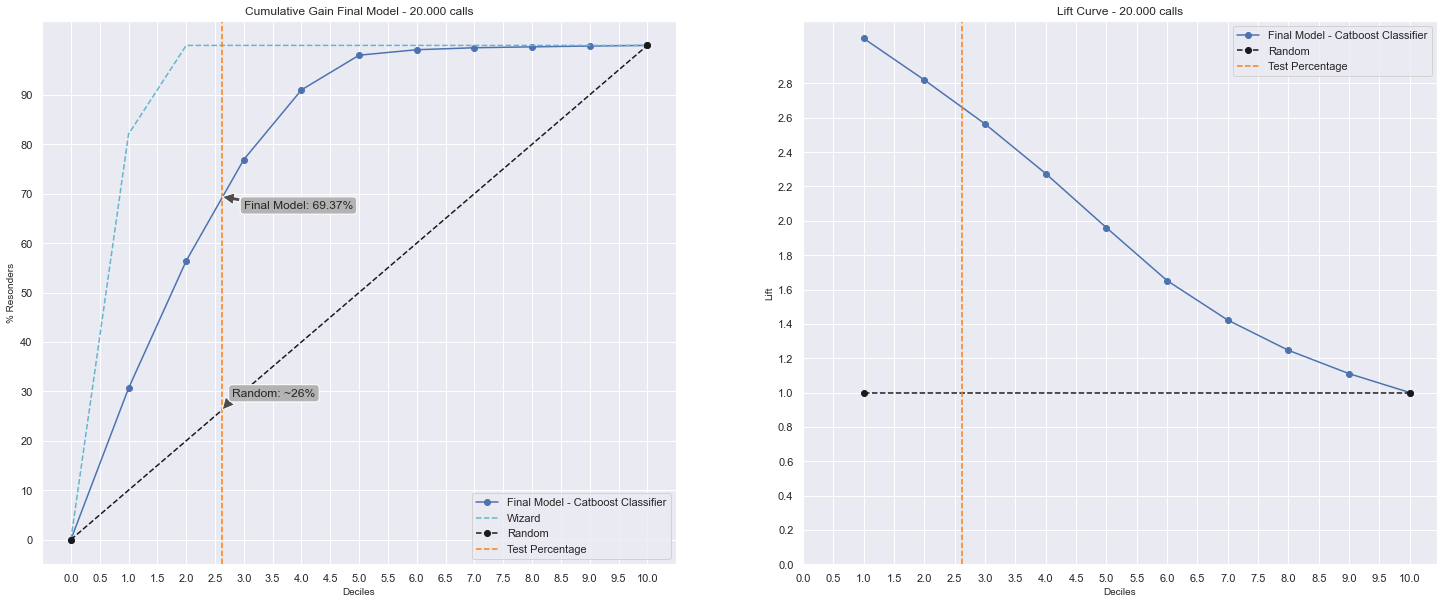

In [94]:
fig, ax = plt.subplots(figsize = (25, 10))

plt.subplot(1, 2, 1)
plot_cumulative_gain(y_val, yhat_catboost_tuned[:,1])
plt.axvline(2.624, color ='#FF7F0E', ls = '--')
plt.title('Cumulative Gain Final Model - 20.000 calls')
plt.yticks(np.arange(0, 100, step = 10))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - Catboost Classifier', 'Wizard', 'Random', 'Test Percentage'])

bbox = dict(boxstyle ='round', fc ='0.7')
arrowprops = dict(facecolor ='#4D4D4D')
plt.annotate('Final Model: 69.37%', xy = (2.624, 69.37),
                xytext =(3, 67), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Random: ~26%', xy = (2.624, 26.24),
                xytext =(2.8, 29), 
                arrowprops = arrowprops, bbox = bbox);



plt.subplot(1, 2, 2)
plot_lift(y_val, yhat_catboost_tuned[:,1])
plt.axvline(2.624, color ='#FF7F0E', ls = '--')
plt.title('Lift Curve - 20.000 calls')
plt.yticks(np.arange(0, 3, step = 0.2))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - Catboost Classifier', 'Random', 'Test Percentage']);

## By increasing the capacity to 40,000 calls, what percentage of interested customers the sales team will be able to contact?

In [95]:
# Define dataset percentage that defines 40.000 calls
percent = round((40000/len(df9)*100), 2)
# Apply Recall metric to define the percentage of interested customers was achieved by phone calling 20.000 people
recall_at_40000 = round((recall_at_k(df9, 40000))*100 , 2 )

print(f'Using {percent}% of the test data, the model could find {recall_at_40000}% of the total customers interested in purchase a car insurance.')

Using 52.48% of the test data, the model could find 98.49% of the total customers interested in purchase a car insurance.


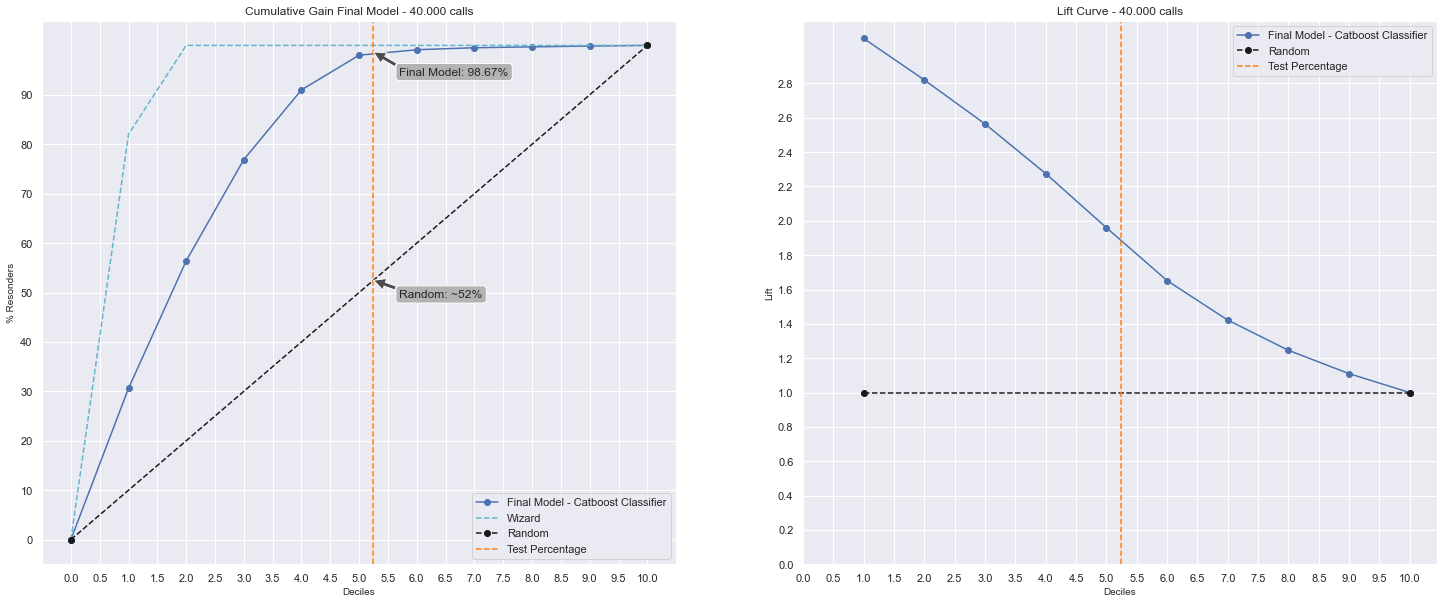

In [96]:
fig, ax = plt.subplots(figsize = (25, 10))

plt.subplot(1, 2, 1)
plot_cumulative_gain(y_val, yhat_catboost_tuned[:,1])
plt.axvline(5.248, color ='#FF7F0E', ls = '--')
plt.title('Cumulative Gain Final Model - 40.000 calls')
plt.yticks(np.arange(0, 100, step = 10))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - Catboost Classifier', 'Wizard', 'Random', 'Test Percentage'])

arrowprops = dict(facecolor ='#4D4D4D')
plt.annotate('Final Model: 98.67%', xy = (5.248, 98.67),
                xytext =(5.7, 94), 
                arrowprops = arrowprops, bbox = bbox)

plt.annotate('Random: ~52%', xy = (5.248, 52.48),
                xytext =(5.7, 49), 
                arrowprops = arrowprops, bbox = bbox);



plt.subplot(1, 2, 2)
plot_lift(y_val, yhat_catboost_tuned[:,1])
plt.axvline(5.248, color ='#FF7F0E', ls = '--')
plt.title('Lift Curve - 40.000 calls')
plt.yticks(np.arange(0, 3, step = 0.2))
plt.xticks(np.arange(0, 10.5, step = 0.5))
plt.legend(['Final Model - Catboost Classifier', 'Random', 'Test Percentage']);